In [1]:
import os
from urllib import request
import numpy as np
import pandas as pd
import zipfile
import json
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import time
import numpy as np
from dataclasses import astuple, dataclass, replace
from typing import Any, Literal, Optional, Union, cast, Tuple, Dict, List
import torch
from pathlib import Path
import enum
from torch import nn
import sklearn
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import torch
import torch.nn.init as nn_init
import torch.nn.functional as F
from torch import Tensor
import math

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print('Device: {}'.format(my_device))

Device: cpu


### Load Adult

In [4]:
class Adult_Dataset():

    def __init__(self, name):
        super(Adult_Dataset, self).__init__()
        self.name = name

    def download_from_uci(self):

        print(f'Start processing dataset {self.name} from UCI.')
        save_dir = f'data/{self.name}'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

            url = 'https://archive.ics.uci.edu/static/public/2/adult.zip'
            request.urlretrieve(url, f'{save_dir}/{self.name}.zip')
            print(
                f'Finish downloading dataset from {url}, data has been saved to {save_dir}.')

            with zipfile.ZipFile(f'{save_dir}/{self.name}.zip', 'r') as zip_ref:
                zip_ref.extractall(save_dir)

            print(f'Finish unzipping {self.name}.')

        else:
            print('Aready downloaded.')

    def get_column_name_mapping(self, data_df, num_col_idx, cat_col_idx, target_col_idx, column_names=None):

        idx_mapping = {}

        curr_num_idx = 0
        curr_cat_idx = len(num_col_idx)
        curr_target_idx = curr_cat_idx + len(cat_col_idx)

        for idx in range(len(column_names)):

            if idx in num_col_idx:
                idx_mapping[int(idx)] = curr_num_idx
                curr_num_idx += 1
            elif idx in cat_col_idx:
                idx_mapping[int(idx)] = curr_cat_idx
                curr_cat_idx += 1
            else:
                idx_mapping[int(idx)] = curr_target_idx
                curr_target_idx += 1

        inverse_idx_mapping = {}
        for k, v in idx_mapping.items():
            inverse_idx_mapping[int(v)] = k

        idx_name_mapping = {}

        for i in range(len(column_names)):
            idx_name_mapping[int(i)] = column_names[i]

        return idx_mapping, inverse_idx_mapping, idx_name_mapping

    def process_data(self):
        with open(f'data/Info/{self.name}.json', 'r') as f:
            info = json.load(f)
        data_path = info['data_path']
        data_df = pd.read_csv(data_path, header=None)

        num_data = data_df.shape[0]

        column_names = [
            "age",
            "workclass",
            "fnlwgt",
            "education",
            "education.num",
            "marital.status",
            "occupation",
            "relationship",
            "race",
            "sex",
            "capital.gain",
            "capital.loss",
            "hours.per.week",
            "native.country",
            "income"
        ]

        num_col_idx = info['num_col_idx']
        cat_col_idx = info['cat_col_idx']
        target_col_idx = info['target_col_idx']

        idx_mapping, inverse_idx_mapping, idx_name_mapping = self.get_column_name_mapping(
            data_df, num_col_idx, cat_col_idx, target_col_idx, column_names)

        num_columns = [column_names[i] for i in num_col_idx]
        cat_columns = [column_names[i] for i in cat_col_idx]
        target_columns = [column_names[i] for i in target_col_idx]

        # if testing data is given
        test_path = info['test_path']

        with open(test_path, 'r') as f:
            lines = f.readlines()[1:]
            test_save_path = f'data/{self.name}/test.data'
            if not os.path.exists(test_save_path):
                with open(test_save_path, 'a') as f1:
                    for line in lines:
                        save_line = line.strip('\n').strip('.')
                        f1.write(f'{save_line}\n')

        test_df = pd.read_csv(test_save_path, header=None)
        train_df = data_df

        train_df.columns = range(len(train_df.columns))
        test_df.columns = range(len(test_df.columns))

        print(self.name, train_df.shape, test_df.shape, data_df.shape)

        col_info = {}

        for col_idx in num_col_idx:
            col_info[col_idx] = {}
            col_info['type'] = 'numerical'
            col_info['max'] = float(train_df[col_idx].max())
            col_info['min'] = float(train_df[col_idx].min())

        for col_idx in cat_col_idx:
            col_info[col_idx] = {}
            col_info['type'] = 'categorical'
            col_info['categorizes'] = list(set(train_df[col_idx]))

        for col_idx in target_col_idx:
            col_info[col_idx] = {}
            col_info['type'] = 'categorical'
            col_info['categorizes'] = list(set(train_df[col_idx]))

        info['column_info'] = col_info

        train_df.rename(columns=idx_name_mapping, inplace=True)
        test_df.rename(columns=idx_name_mapping, inplace=True)

        for col in num_columns:
            train_df.loc[train_df[col] == '?', col] = np.nan
        for col in cat_columns:
            train_df.loc[train_df[col] == '?', col] = 'nan'
        for col in num_columns:
            test_df.loc[test_df[col] == '?', col] = np.nan
        for col in cat_columns:
            test_df.loc[test_df[col] == '?', col] = 'nan'

        X_num_train = train_df[num_columns].to_numpy().astype(np.float32)
        X_cat_train = train_df[cat_columns].to_numpy()
        y_train = train_df[target_columns].to_numpy()

        X_num_test = test_df[num_columns].to_numpy().astype(np.float32)
        X_cat_test = test_df[cat_columns].to_numpy()
        y_test = test_df[target_columns].to_numpy()

        save_dir = f'data/{self.name}'
        np.save(f'{save_dir}/X_num_train.npy', X_num_train)
        np.save(f'{save_dir}/X_cat_train.npy', X_cat_train)
        np.save(f'{save_dir}/y_train.npy', y_train)

        np.save(f'{save_dir}/X_num_test.npy', X_num_test)
        np.save(f'{save_dir}/X_cat_test.npy', X_cat_test)
        np.save(f'{save_dir}/y_test.npy', y_test)

        train_df[num_columns] = train_df[num_columns].astype(np.float32)
        test_df[num_columns] = test_df[num_columns].astype(np.float32)

        train_df.to_csv(f'{save_dir}/train.csv', index=False)
        test_df.to_csv(f'{save_dir}/test.csv', index=False)

        if not os.path.exists(f'synthetic/{self.name}'):
            os.makedirs(f'synthetic/{self.name}')

        train_df.to_csv(f'synthetic/{self.name}/real.csv', index=False)
        test_df.to_csv(f'synthetic/{self.name}/test.csv', index=False)

        print('Numerical', X_num_train.shape)
        print('Categorical', X_cat_train.shape)

        info['column_names'] = column_names
        info['train_num'] = train_df.shape[0]
        info['test_num'] = test_df.shape[0]

        info['idx_mapping'] = idx_mapping
        info['inverse_idx_mapping'] = inverse_idx_mapping
        info['idx_name_mapping'] = idx_name_mapping

        metadata = {'columns': {}}
        num_col_idx = info['num_col_idx']
        cat_col_idx = info['cat_col_idx']
        target_col_idx = info['target_col_idx']

        for i in num_col_idx:
            metadata['columns'][i] = {}
            metadata['columns'][i]['sdtype'] = 'numerical'
            metadata['columns'][i]['computer_representation'] = 'Float'

        for i in cat_col_idx:
            metadata['columns'][i] = {}
            metadata['columns'][i]['sdtype'] = 'categorical'

        for i in target_col_idx:
            metadata['columns'][i] = {}
            metadata['columns'][i]['sdtype'] = 'categorical'

        info['metadata'] = metadata

        with open(f'{save_dir}/info.json', 'w') as file:
            json.dump(info, file, indent=4)

        print(f'Processing and Saving {self.name} Successfully!')

        print(self.name)
        print('Total', info['train_num'] + info['test_num'])
        print('Train', info['train_num'])
        print('Test', info['test_num'])
        cat = len(info['cat_col_idx'] + info['target_col_idx'])
        num = len(info['num_col_idx'])
        print('Num', num)
        print('Cat', cat)

    def start_load(self):
        self.download_from_uci()
        self.process_data()

In [5]:
data_load = Adult_Dataset('adult')
data_load.download_from_uci()
data_load.process_data()

Start processing dataset adult from UCI.
Aready downloaded.


FileNotFoundError: [Errno 2] No such file or directory: 'data/adult/adult.data'

## VAE


### Dataset

In [7]:

ArrayDict = Dict[str, np.ndarray]
TensorDict = Dict[str, torch.Tensor]


CAT_MISSING_VALUE = 'nan'
CAT_RARE_VALUE = '__rare__'
Normalization = Literal['standard', 'quantile', 'minmax']
NumNanPolicy = Literal['drop-rows', 'mean']
CatNanPolicy = Literal['most_frequent']
CatEncoding = Literal['one-hot', 'counter']
YPolicy = Literal['default']

Normalization = Literal['standard', 'quantile', 'minmax']
NumNanPolicy = Literal['drop-rows', 'mean']
CatNanPolicy = Literal['most_frequent']
CatEncoding = Literal['one-hot', 'counter']
YPolicy = Literal['default']
ArrayDict = Dict[str, np.ndarray]
TensorDict = Dict[str, torch.Tensor]


class TaskType(enum.Enum):
    BINCLASS = 'binclass'
    MULTICLASS = 'multiclass'
    REGRESSION = 'regression'

    def __str__(self) -> str:
        return self.value


@dataclass(frozen=True)
class Transformations:
    seed: int = 0
    normalization: Optional[Normalization] = None
    num_nan_policy: Optional[NumNanPolicy] = None
    cat_nan_policy: Optional[CatNanPolicy] = None
    cat_min_frequency: Optional[float] = None
    cat_encoding: Optional[CatEncoding] = None
    y_policy: Optional[YPolicy] = 'default'


@dataclass(frozen=False)
class Dataset:
    X_num: Optional[ArrayDict]
    X_cat: Optional[ArrayDict]
    y: ArrayDict
    y_info: Dict[str, Any]
    task_type: TaskType
    n_classes: Optional[int]

    @classmethod
    def from_dir(cls, dir_: Union[Path, str]) -> 'Dataset':
        dir_ = Path(dir_)
        splits = [k for k in ['train', 'test']
                  if dir_.joinpath(f'y_{k}.npy').exists()]

        def load(item) -> ArrayDict:
            return {
                # type: ignore[code]
                x: cast(np.ndarray, np.load(
                    dir_ / f'{item}_{x}.npy', allow_pickle=True))
                for x in splits
            }

        if Path(dir_ / 'info.json').exists():
            info = util.load_json(dir_ / 'info.json')
        else:
            info = None
        return Dataset(
            load('X_num') if dir_.joinpath(
                'X_num_train.npy').exists() else None,
            load('X_cat') if dir_.joinpath(
                'X_cat_train.npy').exists() else None,
            load('y'),
            {},
            TaskType(info['task_type']),
            info.get('n_classes'),
        )

    @property
    def is_binclass(self) -> bool:
        return self.task_type == TaskType.BINCLASS

    @property
    def is_multiclass(self) -> bool:
        return self.task_type == TaskType.MULTICLASS

    @property
    def is_regression(self) -> bool:
        return self.task_type == TaskType.REGRESSION

    @property
    def n_num_features(self) -> int:
        return 0 if self.X_num is None else self.X_num['train'].shape[1]

    @property
    def n_cat_features(self) -> int:
        return 0 if self.X_cat is None else self.X_cat['train'].shape[1]

    @property
    def n_features(self) -> int:
        return self.n_num_features + self.n_cat_features

    def size(self, part: Optional[str]) -> int:
        return sum(map(len, self.y.values())) if part is None else len(self.y[part])

    @property
    def nn_output_dim(self) -> int:
        if self.is_multiclass:
            assert self.n_classes is not None
            return self.n_classes
        else:
            return 1

    def get_category_sizes(self, part: str) -> List[int]:
        return [] if self.X_cat is None else get_category_sizes(self.X_cat[part])

    def calculate_metrics(
        self,
        predictions: Dict[str, np.ndarray],
        prediction_type: Optional[str],
    ) -> Dict[str, Any]:
        metrics = {
            x: calculate_metrics(
                self.y[x], predictions[x], self.task_type, prediction_type, self.y_info
            )
            for x in predictions
        }
        if self.task_type == TaskType.REGRESSION:
            score_key = 'rmse'
            score_sign = -1
        else:
            score_key = 'accuracy'
            score_sign = 1
        for part_metrics in metrics.values():
            part_metrics['score'] = score_sign * part_metrics[score_key]
        return metrics


class TabularDataset(Dataset):
    def __init__(self, X_num, X_cat):
        self.X_num = X_num
        self.X_cat = X_cat

    def __getitem__(self, index):
        this_num = self.X_num[index]
        this_cat = self.X_cat[index]

        sample = (this_num, this_cat)

        return sample

    def __len__(self):
        return self.X_num.shape[0]


def num_process_nans(dataset: Dataset, policy: Optional[NumNanPolicy]) -> Dataset:

    assert dataset.X_num is not None
    nan_masks = {k: np.isnan(v) for k, v in dataset.X_num.items()}
    if not any(x.any() for x in nan_masks.values()):  # type: ignore[code]
        # assert policy is None
        print('No NaNs in numerical features, skipping')
        return dataset

    assert policy is not None
    if policy == 'drop-rows':
        valid_masks = {k: ~v.any(1) for k, v in nan_masks.items()}
        assert valid_masks[
            'test'
        ].all(), 'Cannot drop test rows, since this will affect the final metrics.'
        new_data = {}
        for data_name in ['X_num', 'X_cat', 'y']:
            data_dict = getattr(dataset, data_name)
            if data_dict is not None:
                new_data[data_name] = {
                    k: v[valid_masks[k]] for k, v in data_dict.items()
                }
        dataset = replace(dataset, **new_data)
    elif policy == 'mean':
        new_values = np.nanmean(dataset.X_num['train'], axis=0)
        X_num = deepcopy(dataset.X_num)
        for k, v in X_num.items():
            num_nan_indices = np.where(nan_masks[k])
            v[num_nan_indices] = np.take(new_values, num_nan_indices[1])
        dataset = replace(dataset, X_num=X_num)
    # else:
    #     assert raise_unknown('policy', policy)
    return dataset


def normalize(
    X: ArrayDict, normalization: Normalization, seed: Optional[int], return_normalizer: bool = False
) -> ArrayDict:
    X_train = X['train']
    if normalization == 'standard':
        normalizer = preprocessing.StandardScaler()
    elif normalization == 'minmax':
        normalizer = preprocessing.MinMaxScaler()
    elif normalization == 'quantile':
        normalizer = preprocessing.QuantileTransformer(
            output_distribution='normal',
            n_quantiles=max(min(X['train'].shape[0] // 30, 1000), 10),
            subsample=int(1e9),
            random_state=seed,
        )
    # else:
    #     raise_unknown('normalization', normalization)

    normalizer.fit(X_train)
    if return_normalizer:
        return {k: normalizer.transform(v) for k, v in X.items()}, normalizer
    return {k: normalizer.transform(v) for k, v in X.items()}


def cat_process_nans(X: ArrayDict, policy: Optional[CatNanPolicy]) -> ArrayDict:
    assert X is not None
    nan_masks = {k: v == CAT_MISSING_VALUE for k, v in X.items()}
    if any(x.any() for x in nan_masks.values()):  # type: ignore[code]
        if policy is None:
            X_new = X
        elif policy == 'most_frequent':
            imputer = SimpleImputer(
                missing_values=CAT_MISSING_VALUE, strategy=policy)  # type: ignore[code]
            imputer.fit(X['train'])
            X_new = {k: cast(np.ndarray, imputer.transform(v))
                     for k, v in X.items()}
        # else:
        #     util.raise_unknown('categorical NaN policy', policy)
    else:
        assert policy is None
        X_new = X
    return X_new


def cat_encode(
    X: ArrayDict,
    encoding: Optional[CatEncoding],
    y_train: Optional[np.ndarray],
    seed: Optional[int],
    return_encoder: bool = False
) -> Tuple[ArrayDict, bool, Optional[Any]]:  # (X, is_converted_to_numerical)
    if encoding != 'counter':
        y_train = None

    # Step 1. Map strings to 0-based ranges

    if encoding is None:
        unknown_value = np.iinfo('int64').max - 3
        oe = preprocessing.OrdinalEncoder(
            handle_unknown='use_encoded_value',  # type: ignore[code]
            unknown_value=unknown_value,  # type: ignore[code]
            dtype='int64',  # type: ignore[code]
        ).fit(X['train'])
        encoder = make_pipeline(oe)
        encoder.fit(X['train'])
        X = {k: encoder.transform(v) for k, v in X.items()}
        max_values = X['train'].max(axis=0)
        for part in X.keys():
            if part == 'train':
                continue
            for column_idx in range(X[part].shape[1]):
                X[part][X[part][:, column_idx] == unknown_value, column_idx] = (
                    max_values[column_idx] + 1
                )
        if return_encoder:
            return (X, False, encoder)
        return (X, False)


def build_target(
    y: ArrayDict, policy: Optional[YPolicy], task_type: TaskType
) -> Tuple[ArrayDict, Dict[str, Any]]:
    info: Dict[str, Any] = {'policy': policy}
    if policy is None:
        pass
    elif policy == 'default':
        if task_type == TaskType.REGRESSION:
            mean, std = float(y['train'].mean()), float(y['train'].std())
            y = {k: (v - mean) / std for k, v in y.items()}
            info['mean'] = mean
            info['std'] = std
    # else:
    #     raise_unknown('policy', policy)
    return y, info


def transform_dataset(
    dataset: Dataset,
    transformations: Transformations,
    cache_dir: Optional[Path],
    return_transforms: bool = False
) -> Dataset:
    # WARNING: the order of transformations matters. Moreover, the current
    # implementation is not ideal in that sense.
    if cache_dir is not None:
        transformations_md5 = hashlib.md5(
            str(transformations).encode('utf-8')
        ).hexdigest()
        transformations_str = '__'.join(map(str, astuple(transformations)))
        cache_path = (
            cache_dir /
            f'cache__{transformations_str}__{transformations_md5}.pickle'
        )
        if cache_path.exists():
            cache_transformations, value = util.load_pickle(cache_path)
            if transformations == cache_transformations:
                print(
                    f"Using cached features: {cache_dir.name + '/' + cache_path.name}"
                )
                return value
            else:
                raise RuntimeError(f'Hash collision for {cache_path}')
    else:
        cache_path = None

    if dataset.X_num is not None:
        dataset = num_process_nans(dataset, transformations.num_nan_policy)

    num_transform = None
    cat_transform = None
    X_num = dataset.X_num

    if X_num is not None and transformations.normalization is not None:
        X_num, num_transform = normalize(
            X_num,
            transformations.normalization,
            transformations.seed,
            return_normalizer=True
        )
        num_transform = num_transform

    if dataset.X_cat is None:
        assert transformations.cat_nan_policy is None
        assert transformations.cat_min_frequency is None
        # assert transformations.cat_encoding is None
        X_cat = None
    else:
        X_cat = cat_process_nans(dataset.X_cat, transformations.cat_nan_policy)

        if transformations.cat_min_frequency is not None:
            X_cat = cat_drop_rare(X_cat, transformations.cat_min_frequency)
        X_cat, is_num, cat_transform = cat_encode(
            X_cat,
            transformations.cat_encoding,
            dataset.y['train'],
            transformations.seed,
            return_encoder=True
        )

        if is_num:
            X_num = (
                X_cat
                if X_num is None
                else {x: np.hstack([X_num[x], X_cat[x]]) for x in X_num}
            )
            X_cat = None

    y, y_info = build_target(
        dataset.y, transformations.y_policy, dataset.task_type)

    dataset = replace(dataset, X_num=X_num, X_cat=X_cat, y=y, y_info=y_info)
    dataset.num_transform = num_transform
    dataset.cat_transform = cat_transform

    # if cache_path is not None:
    #     util.dump_pickle((transformations, dataset), cache_path)
    # if return_transforms:
    # return dataset, num_transform, cat_transform
    return dataset


def get_categories(X_train_cat):
    return (
        None
        if X_train_cat is None
        else [
            len(set(X_train_cat[:, i]))
            for i in range(X_train_cat.shape[1])
        ]
    )


def read_pure_data(path, split='train'):
    y = np.load(os.path.join(path, f'y_{split}.npy'), allow_pickle=True)
    X_num = None
    X_cat = None
    if os.path.exists(os.path.join(path, f'X_num_{split}.npy')):
        X_num = np.load(os.path.join(
            path, f'X_num_{split}.npy'), allow_pickle=True)
    if os.path.exists(os.path.join(path, f'X_cat_{split}.npy')):
        X_cat = np.load(os.path.join(
            path, f'X_cat_{split}.npy'), allow_pickle=True)

    return X_num, X_cat, y


def concat_y_to_X(X, y):
    if X is None:
        return y.reshape(-1, 1)
    return np.concatenate([y.reshape(-1, 1), X], axis=1)


def load_json(path: Union[Path, str], **kwargs) -> Any:
    return json.loads(Path(path).read_text(), **kwargs)


def make_dataset(
    data_path: str,
    T: Transformations,
    task_type,
    change_val: bool,
    concat=True,
):

    X_cat = {} if os.path.exists(os.path.join(
        data_path, 'X_cat_train.npy')) else None
    X_num = {} if os.path.exists(os.path.join(
        data_path, 'X_num_train.npy')) else None
    y = {} if os.path.exists(os.path.join(data_path, 'y_train.npy')) else None

    for split in ['train', 'test']:
        X_num_t, X_cat_t, y_t = read_pure_data(data_path, split)
        if X_num is not None:
            X_num[split] = X_num_t
        if X_cat is not None:
            if concat:
                X_cat_t = concat_y_to_X(X_cat_t, y_t)
            X_cat[split] = X_cat_t
        if y is not None:
            y[split] = y_t

    # with open(f'data/Info/{self.name}.json', 'r') as f:
    #     info = json.load(f)
    info = load_json(os.path.join(data_path, 'info.json'))
    D = Dataset(
        X_num,
        X_cat,
        y,
        y_info={},
        task_type=TaskType(info['task_type']),
        n_classes=info.get('n_classes')
    )

    return transform_dataset(D, T, None)


def preprocess(dataset_path, task_type='binclass', inverse=False, cat_encoding=None, concat=True):
    T_dict = {}

    T_dict['normalization'] = "quantile"
    T_dict['num_nan_policy'] = 'mean'
    T_dict['cat_nan_policy'] = None
    T_dict['cat_min_frequency'] = None
    T_dict['cat_encoding'] = cat_encoding
    T_dict['y_policy'] = "default"

    T = Transformations(**T_dict)

    dataset = make_dataset(
        data_path=dataset_path,
        T=T,
        task_type=task_type,
        change_val=False,
        concat=concat
    )

    if cat_encoding is None:
        X_num = dataset.X_num
        X_cat = dataset.X_cat

        X_train_num, X_test_num = X_num['train'], X_num['test']
        X_train_cat, X_test_cat = X_cat['train'], X_cat['test']

        categories = get_categories(X_train_cat)
        d_numerical = X_train_num.shape[1]

        X_num = (X_train_num, X_test_num)
        X_cat = (X_train_cat, X_test_cat)

        if inverse:
            num_inverse = dataset.num_transform.inverse_transform
            cat_inverse = dataset.cat_transform.inverse_transform

            return X_num, X_cat, categories, d_numerical, num_inverse, cat_inverse
        else:
            return X_num, X_cat, categories, d_numerical
    else:
        return dataset

### VAE architecture

In [8]:
class MultiheadAttention(nn.Module):
    def __init__(self, d, n_heads, dropout, initialization='kaiming'):

        if n_heads > 1:
            assert d % n_heads == 0
        assert initialization in ['xavier', 'kaiming']

        super().__init__()
        self.W_q = nn.Linear(d, d)
        self.W_k = nn.Linear(d, d)
        self.W_v = nn.Linear(d, d)
        self.W_out = nn.Linear(d, d) if n_heads > 1 else None
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout) if dropout else None

        for m in [self.W_q, self.W_k, self.W_v]:
            if initialization == 'xavier' and (n_heads > 1 or m is not self.W_v):
                # gain is needed since W_qkv is represented with 3 separate layers
                nn_init.xavier_uniform_(m.weight, gain=1 / math.sqrt(2))
            nn_init.zeros_(m.bias)
        if self.W_out is not None:
            nn_init.zeros_(self.W_out.bias)

    def _reshape(self, x):
        batch_size, n_tokens, d = x.shape
        d_head = d // self.n_heads
        return (
            x.reshape(batch_size, n_tokens, self.n_heads, d_head)
            .transpose(1, 2)
            .reshape(batch_size * self.n_heads, n_tokens, d_head)
        )

    def forward(self, x_q, x_kv, key_compression=None, value_compression=None):

        q, k, v = self.W_q(x_q), self.W_k(x_kv), self.W_v(x_kv)
        for tensor in [q, k, v]:
            assert tensor.shape[-1] % self.n_heads == 0
        if key_compression is not None:
            assert value_compression is not None
            k = key_compression(k.transpose(1, 2)).transpose(1, 2)
            v = value_compression(v.transpose(1, 2)).transpose(1, 2)
        else:
            assert value_compression is None

        batch_size = len(q)
        d_head_key = k.shape[-1] // self.n_heads
        d_head_value = v.shape[-1] // self.n_heads
        n_q_tokens = q.shape[1]

        q = self._reshape(q)
        k = self._reshape(k)

        a = q @ k.transpose(1, 2)
        b = math.sqrt(d_head_key)
        attention = F.softmax(a/b, dim=-1)

        if self.dropout is not None:
            attention = self.dropout(attention)
        x = attention @ self._reshape(v)
        x = (
            x.reshape(batch_size, self.n_heads, n_q_tokens, d_head_value)
            .transpose(1, 2)
            .reshape(batch_size, n_q_tokens, self.n_heads * d_head_value)
        )
        if self.W_out is not None:
            x = self.W_out(x)

        return x


class Tokenizer(nn.Module):

    def __init__(self, d_numerical, categories, d_token, bias):
        super().__init__()
        if categories is None:
            d_bias = d_numerical
            self.category_offsets = None
            self.category_embeddings = None
        else:
            d_bias = d_numerical + len(categories)
            category_offsets = torch.tensor([0] + categories[:-1]).cumsum(0)
            self.register_buffer('category_offsets', category_offsets)
            self.category_embeddings = nn.Embedding(sum(categories), d_token)
            nn_init.kaiming_uniform_(
                self.category_embeddings.weight, a=math.sqrt(5))
            print(f'{self.category_embeddings.weight.shape=}')

        # take [CLS] token into account
        self.weight = nn.Parameter(Tensor(d_numerical + 1, d_token))
        self.bias = nn.Parameter(Tensor(d_bias, d_token)) if bias else None
        # The initialization is inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    @property
    def n_tokens(self):
        return len(self.weight) + (
            0 if self.category_offsets is None else len(self.category_offsets)
        )

    def forward(self, x_num, x_cat):
        x_some = x_num if x_cat is None else x_cat
        assert x_some is not None
        x_num = torch.cat(
            [torch.ones(len(x_some), 1, device=x_some.device)]  # [CLS]
            + ([] if x_num is None else [x_num]),
            dim=1,
        )

        x = self.weight[None] * x_num[:, :, None]

        if x_cat is not None:
            x = torch.cat(
                [x, self.category_embeddings(
                    x_cat + self.category_offsets[None])],
                dim=1,
            )
        if self.bias is not None:
            bias = torch.cat(
                [
                    torch.zeros(1, self.bias.shape[1], device=x.device),
                    self.bias,
                ]
            )
            x = x + bias[None]

        return x


class Transformer(nn.Module):

    def __init__(
        self,
        n_layers: int,
        d_token: int,
        n_heads: int,
        d_out: int,
        d_ffn_factor: int,
        attention_dropout=0.0,
        ffn_dropout=0.0,
        residual_dropout=0.0,
        activation='relu',
        prenormalization=True,
        initialization='kaiming',
    ):
        super().__init__()

        def make_normalization():
            return nn.LayerNorm(d_token)

        d_hidden = int(d_token * d_ffn_factor)
        self.layers = nn.ModuleList([])
        for layer_idx in range(n_layers):
            layer = nn.ModuleDict(
                {
                    'attention': MultiheadAttention(
                        d_token, n_heads, attention_dropout, initialization
                    ),
                    'linear0': nn.Linear(
                        d_token, d_hidden
                    ),
                    'linear1': nn.Linear(d_hidden, d_token),
                    'norm1': make_normalization(),
                }
            )
            if not prenormalization or layer_idx:
                layer['norm0'] = make_normalization()

            self.layers.append(layer)

        self.activation = nn.ReLU()
        self.last_activation = nn.ReLU()
        # self.activation = lib.get_activation_fn(activation)
        # self.last_activation = lib.get_nonglu_activation_fn(activation)
        self.prenormalization = prenormalization
        self.last_normalization = make_normalization() if prenormalization else None
        self.ffn_dropout = ffn_dropout
        self.residual_dropout = residual_dropout
        self.head = nn.Linear(d_token, d_out)

    def _start_residual(self, x, layer, norm_idx):
        x_residual = x
        if self.prenormalization:
            norm_key = f'norm{norm_idx}'
            if norm_key in layer:
                x_residual = layer[norm_key](x_residual)
        return x_residual

    def _end_residual(self, x, x_residual, layer, norm_idx):
        if self.residual_dropout:
            x_residual = F.dropout(
                x_residual, self.residual_dropout, self.training)
        x = x + x_residual
        if not self.prenormalization:
            x = layer[f'norm{norm_idx}'](x)
        return x

    def forward(self, x):
        for layer_idx, layer in enumerate(self.layers):
            is_last_layer = layer_idx + 1 == len(self.layers)

            x_residual = self._start_residual(x, layer, 0)
            x_residual = layer['attention'](
                # for the last attention, it is enough to process only [CLS]
                x_residual,
                x_residual,
            )

            x = self._end_residual(x, x_residual, layer, 0)

            x_residual = self._start_residual(x, layer, 1)
            x_residual = layer['linear0'](x_residual)
            x_residual = self.activation(x_residual)
            if self.ffn_dropout:
                x_residual = F.dropout(
                    x_residual, self.ffn_dropout, self.training)
            x_residual = layer['linear1'](x_residual)
            x = self._end_residual(x, x_residual, layer, 1)
        return x


class VAE(nn.Module):
    def __init__(self, d_numerical, categories, num_layers, hid_dim, n_head=1, factor=4, bias=True):
        super(VAE, self).__init__()

        self.d_numerical = d_numerical
        self.categories = categories
        self.hid_dim = hid_dim
        d_token = hid_dim
        self.n_head = n_head

        self.Tokenizer = Tokenizer(d_numerical, categories, d_token, bias=bias)

        self.encoder_mu = Transformer(
            num_layers, hid_dim, n_head, hid_dim, factor)
        self.encoder_logvar = Transformer(
            num_layers, hid_dim, n_head, hid_dim, factor)

        self.decoder = Transformer(
            num_layers, hid_dim, n_head, hid_dim, factor)

    def get_embedding(self, x):
        return self.encoder_mu(x, x).detach()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_num, x_cat):
        x = self.Tokenizer(x_num, x_cat)

        mu_z = self.encoder_mu(x)
        std_z = self.encoder_logvar(x)

        z = self.reparameterize(mu_z, std_z)

        batch_size = x_num.size(0)
        h = self.decoder(z[:, 1:])

        return h, mu_z, std_z


class Reconstructor(nn.Module):
    def __init__(self, d_numerical, categories, d_token):
        super(Reconstructor, self).__init__()

        self.d_numerical = d_numerical
        self.categories = categories
        self.d_token = d_token

        self.weight = nn.Parameter(Tensor(d_numerical, d_token))
        nn.init.xavier_uniform_(self.weight, gain=1 / math.sqrt(2))
        self.cat_recons = nn.ModuleList()

        for d in categories:
            recon = nn.Linear(d_token, d)
            nn.init.xavier_uniform_(recon.weight, gain=1 / math.sqrt(2))
            self.cat_recons.append(recon)

    def forward(self, h):
        h_num = h[:, :self.d_numerical]
        h_cat = h[:, self.d_numerical:]

        recon_x_num = torch.mul(h_num, self.weight.unsqueeze(0)).sum(-1)
        recon_x_cat = []

        for i, recon in enumerate(self.cat_recons):

            recon_x_cat.append(recon(h_cat[:, i]))

        return recon_x_num, recon_x_cat


class Model_VAE(nn.Module):
    def __init__(self, num_layers, d_numerical, categories, d_token, n_head=1, factor=4,  bias=True):
        super(Model_VAE, self).__init__()

        self.VAE = VAE(d_numerical, categories, num_layers,
                       d_token, n_head=n_head, factor=factor, bias=bias)
        self.Reconstructor = Reconstructor(d_numerical, categories, d_token)

    def get_embedding(self, x_num, x_cat):
        x = self.Tokenizer(x_num, x_cat)
        return self.VAE.get_embedding(x)

    def forward(self, x_num, x_cat):

        h, mu_z, std_z = self.VAE(x_num, x_cat)

        # recon_x_num, recon_x_cat = self.Reconstructor(h[:, 1:])
        recon_x_num, recon_x_cat = self.Reconstructor(h)

        return recon_x_num, recon_x_cat, mu_z, std_z


class Encoder_model(nn.Module):
    def __init__(self, num_layers, d_numerical, categories, d_token, n_head, factor, bias=True):
        super(Encoder_model, self).__init__()
        self.Tokenizer = Tokenizer(d_numerical, categories, d_token, bias)
        self.VAE_Encoder = Transformer(
            num_layers, d_token, n_head, d_token, factor)

    def load_weights(self, Pretrained_VAE):
        self.Tokenizer.load_state_dict(
            Pretrained_VAE.VAE.Tokenizer.state_dict())
        self.VAE_Encoder.load_state_dict(
            Pretrained_VAE.VAE.encoder_mu.state_dict())

    def forward(self, x_num, x_cat):
        x = self.Tokenizer(x_num, x_cat)
        z = self.VAE_Encoder(x)

        return z


class Decoder_model(nn.Module):
    def __init__(self, num_layers, d_numerical, categories, d_token, n_head, factor, bias=True):
        super(Decoder_model, self).__init__()
        self.VAE_Decoder = Transformer(
            num_layers, d_token, n_head, d_token, factor)
        self.Detokenizer = Reconstructor(d_numerical, categories, d_token)

    def load_weights(self, Pretrained_VAE):
        self.VAE_Decoder.load_state_dict(
            Pretrained_VAE.VAE.decoder.state_dict())
        self.Detokenizer.load_state_dict(
            Pretrained_VAE.Reconstructor.state_dict())

    def forward(self, z):

        h = self.VAE_Decoder(z)
        x_hat_num, x_hat_cat = self.Detokenizer(h)

        return x_hat_num, x_hat_cat

In [ ]:
def get_category_sizes(self, part: str) -> List[int]:
    return [] if self.X_cat is None else get_category_sizes(self.X_cat[part])


def calculate_metrics(
    self,
    predictions: Dict[str, np.ndarray],
    prediction_type: Optional[str],
) -> Dict[str, Any]:
    metrics = {
        x: calculate_metrics(
            self.y[x], predictions[x], self.task_type, prediction_type, self.y_info
        )
        for x in predictions
    }
    if self.task_type == TaskType.REGRESSION:
        score_key = 'rmse'
        score_sign = -1
    else:
        score_key = 'accuracy'
        score_sign = 1
    for part_metrics in metrics.values():
        part_metrics['score'] = score_sign * part_metrics[score_key]
    return metrics


def compute_loss(X_num, X_cat, Recon_X_num, Recon_X_cat, mu_z, logvar_z):
    ce_loss_fn = nn.CrossEntropyLoss()
    mse_loss = (X_num - Recon_X_num).pow(2).mean()
    ce_loss = 0
    acc = 0
    total_num = 0

    for idx, x_cat in enumerate(Recon_X_cat):
        if x_cat is not None:
            ce_loss += ce_loss_fn(x_cat, X_cat[:, idx])
            x_hat = x_cat.argmax(dim=-1)
        acc += (x_hat == X_cat[:, idx]).float().sum()
        total_num += x_hat.shape[0]

    ce_loss /= (idx + 1)
    acc /= total_num
    # loss = mse_loss + ce_loss

    temp = 1 + logvar_z - mu_z.pow(2) - logvar_z.exp()

    loss_kld = -0.5 * torch.mean(temp.mean(-1).mean())
    return mse_loss, ce_loss, loss_kld, acc


class VAE_main():
    def __init__(self, name, LR, WD, D_TOKEN, N_HEAD, FACTOR, NUM_LAYERS):
        super(VAE_main, self).__init__()
        self.name = name
        self.LR = LR
        self.WD = WD
        self.D_TOKEN = D_TOKEN
        self.N_HEAD = N_HEAD
        self.FACTOR = FACTOR
        self.NUM_LAYERS = NUM_LAYERS

    def tabsyn_vae_main(self, dataname='adult', max_beta=1e-2, min_beta=1e-5, lambd=0.7, device='cpu', num_epochs=10):

        data_dir = f'data/{dataname}'

        ckpt_dir = f'model'

        model_save_path = f'{ckpt_dir}/model.pt'
        encoder_save_path = f'{ckpt_dir}/encoder.pt'
        decoder_save_path = f'{ckpt_dir}/decoder.pt'
        if not os.path.exists('model'):
            os.makedirs('model')
        X_num, X_cat, categories, d_numerical = preprocess(data_dir)

        X_train_num, _ = X_num
        X_train_cat, _ = X_cat

        X_train_num, X_test_num = X_num
        X_train_cat, X_test_cat = X_cat

        X_train_num, X_test_num = torch.tensor(
            X_train_num).float(), torch.tensor(X_test_num).float()
        X_train_cat, X_test_cat = torch.tensor(
            X_train_cat), torch.tensor(X_test_cat)

        train_data = TabularDataset(X_train_num.float(), X_train_cat)

        X_test_num = X_test_num.float().to(device)
        X_test_cat = X_test_cat.to(device)

        batch_size = 4096
        train_loader = DataLoader(
            train_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
        )

        model = Model_VAE(self.NUM_LAYERS, d_numerical, categories,
                          self.D_TOKEN, n_head=self.N_HEAD, factor=self.FACTOR, bias=True)
        model = model.to(device)

        pre_encoder = Encoder_model(self.NUM_LAYERS, d_numerical, categories,
                                    self.D_TOKEN, n_head=self.N_HEAD, factor=self.FACTOR).to(device)
        pre_decoder = Decoder_model(self.NUM_LAYERS, d_numerical, categories,
                                    self.D_TOKEN, n_head=self.N_HEAD, factor=self.FACTOR).to(device)

        pre_encoder.eval()
        pre_decoder.eval()

        optimizer = torch.optim.Adam(
            model.parameters(), lr=self.LR, weight_decay=self.WD)
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=0.95, patience=10, verbose=True)

        # num_epochs = 10
        best_train_loss = float('inf')

        current_lr = optimizer.param_groups[0]['lr']
        patience = 0

        beta = max_beta
        start_time = time.time()
        for epoch in range(num_epochs):
            # pbar = tqdm(train_loader, total=len(train_loader))
            # pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

            curr_loss_multi = 0.0
            curr_loss_gauss = 0.0
            curr_loss_kl = 0.0

            curr_count = 0

            for batch_num, batch_cat in train_loader:  # pbar
                model.train()
                optimizer.zero_grad()

                batch_num = batch_num.to(device)
                batch_cat = batch_cat.to(device)

                Recon_X_num, Recon_X_cat, mu_z, std_z = model(
                    batch_num, batch_cat)

                loss_mse, loss_ce, loss_kld, train_acc = compute_loss(
                    batch_num, batch_cat, Recon_X_num, Recon_X_cat, mu_z, std_z)

                loss = loss_mse + loss_ce + beta * loss_kld
                loss.backward()
                optimizer.step()

                batch_length = batch_num.shape[0]
                curr_count += batch_length
                curr_loss_multi += loss_ce.item() * batch_length
                curr_loss_gauss += loss_mse.item() * batch_length
                curr_loss_kl += loss_kld.item() * batch_length

            num_loss = curr_loss_gauss / curr_count
            cat_loss = curr_loss_multi / curr_count
            kl_loss = curr_loss_kl / curr_count

            '''
                Evaluation
            '''
            model.eval()
            with torch.no_grad():
                Recon_X_num, Recon_X_cat, mu_z, std_z = model(
                    X_test_num, X_test_cat)

                val_mse_loss, val_ce_loss, val_kl_loss, val_acc = compute_loss(
                    X_test_num, X_test_cat, Recon_X_num, Recon_X_cat, mu_z, std_z)
                val_loss = val_mse_loss.item() * 0 + val_ce_loss.item()

                scheduler.step(val_loss)
                new_lr = optimizer.param_groups[0]['lr']

                if new_lr != current_lr:
                    current_lr = new_lr
                    print(f"Learning rate updated: {current_lr}")

                train_loss = val_loss
                if train_loss < best_train_loss:
                    best_train_loss = train_loss
                    patience = 0
                    torch.save(model.state_dict(), model_save_path)
                else:
                    patience += 1
                    if patience == 10:
                        if beta > min_beta:
                            beta = beta * lambd
            if epoch % 100 == 0:
                print('epoch: {}, beta = {:.6f}, Train MSE: {:.6f}, Train CE:{:.6f}, Train KL:{:.6f}, Val MSE:{:.6f}, Val CE:{:.6f}, Train ACC:{:6f}, Val ACC:{:6f}'.format(
                    epoch, beta, num_loss, cat_loss, kl_loss, val_mse_loss.item(), val_ce_loss.item(), train_acc.item(), val_acc.item()))

        end_time = time.time()
        print('Training time: {:.4f} mins'.format((end_time - start_time)/60))

        # Saving latent embeddings
        with torch.no_grad():
            pre_encoder.load_weights(model)
            pre_decoder.load_weights(model)

            torch.save(pre_encoder.state_dict(), encoder_save_path)
            torch.save(pre_decoder.state_dict(), decoder_save_path)

            X_train_num = X_train_num.to(device)
            X_train_cat = X_train_cat.to(device)

            print('Successfully load and save the model!')

            train_z = pre_encoder(
                X_train_num, X_train_cat).detach().cpu().numpy()

            np.save(f'{ckpt_dir}/train_z.npy', train_z)

            print('Successfully save pretrained embeddings in disk!')

In [ ]:
N_HEAD = 1
FACTOR = 32
NUM_LAYERS = 2
LR = 1e-3
WD = 0
D_TOKEN = 4
TOKEN_BIAS = True

In [9]:
N_HEAD = 1
FACTOR = 32
NUM_LAYERS = 2
LR = 1e-3
WD = 0
D_TOKEN = 4
TOKEN_BIAS = True

vae_train = VAE_main(name='adult', LR=LR, WD=WD,
                     D_TOKEN=D_TOKEN, N_HEAD=N_HEAD,
                     FACTOR=FACTOR, NUM_LAYERS=NUM_LAYERS)

NameError: name 'VAE_main' is not defined

In [ ]:
vae_train.tabsyn_vae_main(device=my_device, num_epochs=4000)

No NaNs in numerical features, skipping


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


self.category_embeddings.weight.shape=torch.Size([104, 4])
self.category_embeddings.weight.shape=torch.Size([104, 4])


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


epoch: 0, beta = 0.010000, Train MSE: 4.830627, Train CE:2.232971, Train KL:0.651672, Val MSE:3.293746, Val CE:2.250790, Train ACC:0.198194, Val ACC:0.197135
epoch: 100, beta = 0.010000, Train MSE: 0.006418, Train CE:0.024796, Train KL:3.209449, Val MSE:0.006479, Val CE:0.024573, Train ACC:0.996086, Val ACC:0.995701
epoch: 200, beta = 0.010000, Train MSE: 0.003328, Train CE:0.006963, Train KL:2.314294, Val MSE:0.003446, Val CE:0.006976, Train ACC:0.998857, Val ACC:0.998908
epoch: 300, beta = 0.010000, Train MSE: 0.003226, Train CE:0.003650, Train KL:2.016403, Val MSE:0.003014, Val CE:0.003681, Train ACC:0.999400, Val ACC:0.999454
epoch: 400, beta = 0.007000, Train MSE: 0.001554, Train CE:0.001874, Train KL:1.950499, Val MSE:0.001428, Val CE:0.001794, Train ACC:0.999771, Val ACC:0.999788
Learning rate updated: 0.00095
epoch: 500, beta = 0.004900, Train MSE: 0.000946, Train CE:0.000910, Train KL:1.985098, Val MSE:0.000970, Val CE:0.000821, Train ACC:0.999943, Val ACC:0.999980
Learning ra

## TabSyn

In [ ]:
class PositionalEmbedding(torch.nn.Module):
    def __init__(self, num_channels, max_positions=10000, endpoint=False):
        super().__init__()
        self.num_channels = num_channels
        self.max_positions = max_positions
        self.endpoint = endpoint

    def forward(self, x):
        freqs = torch.arange(start=0, end=self.num_channels //
                             2, dtype=torch.float32, device=x.device)
        freqs = freqs / (self.num_channels // 2 - (1 if self.endpoint else 0))
        freqs = (1 / self.max_positions) ** freqs
        x = x.ger(freqs.to(x.dtype))
        x = torch.cat([x.cos(), x.sin()], dim=1)
        return x


class MLPDiffusion(nn.Module):
    def __init__(self, d_in, dim_t=512):
        super().__init__()
        self.dim_t = dim_t

        self.proj = nn.Linear(d_in, dim_t)

        self.mlp = nn.Sequential(
            nn.Linear(dim_t, dim_t * 2),
            nn.SiLU(),
            nn.Linear(dim_t * 2, dim_t * 2),
            nn.SiLU(),
            nn.Linear(dim_t * 2, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, d_in),
        )

        self.map_noise = PositionalEmbedding(num_channels=dim_t)
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t),
            nn.SiLU(),
            nn.Linear(dim_t, dim_t)
        )

    def forward(self, x, noise_labels, class_labels=None):
        emb = self.map_noise(noise_labels)
        emb = emb.reshape(
            emb.shape[0], 2, -1).flip(1).reshape(*emb.shape)  # swap sin/cos
        emb = self.time_embed(emb)

        x = self.proj(x) + emb
        return self.mlp(x)


class EDMLoss:
    def __init__(self, P_mean=-1.2, P_std=1.2, sigma_data=0.5, hid_dim=100, gamma=5, opts=None):
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data
        self.hid_dim = hid_dim
        self.gamma = gamma
        self.opts = opts

    def __call__(self, denoise_fn, data):

        rnd_normal = torch.randn(data.shape[0], device=data.device)
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()

        weight = (sigma ** 2 + self.sigma_data ** 2) / \
            (sigma * self.sigma_data) ** 2

        y = data
        n = torch.randn_like(y) * sigma.unsqueeze(1)
        D_yn = denoise_fn(y + n, sigma)

        target = y
        loss = weight.unsqueeze(1) * ((D_yn - target) ** 2)

        return loss


class Precond(nn.Module):
    def __init__(self,
                 denoise_fn,
                 hid_dim,
                 sigma_min=0,                # Minimum supported noise level.
                 sigma_max=float('inf'),     # Maximum supported noise level.
                 # Expected standard deviation of the training data.
                 sigma_data=0.5,
                 ):
        super().__init__()

        self.hid_dim = hid_dim
        self.sigma_min = sigma_min
        self.sigma_max = sigma_max
        self.sigma_data = sigma_data
        self.denoise_fn_F = denoise_fn

    def forward(self, x, sigma):

        x = x.to(torch.float32)

        sigma = sigma.to(torch.float32).reshape(-1, 1)
        dtype = torch.float32

        c_skip = self.sigma_data ** 2 / (sigma ** 2 + self.sigma_data ** 2)
        c_out = sigma * self.sigma_data / \
            (sigma ** 2 + self.sigma_data ** 2).sqrt()
        c_in = 1 / (self.sigma_data ** 2 + sigma ** 2).sqrt()
        c_noise = sigma.log() / 4

        x_in = c_in * x
        F_x = self.denoise_fn_F((x_in).to(dtype), c_noise.flatten())

        assert F_x.dtype == dtype
        D_x = c_skip * x + c_out * F_x.to(torch.float32)
        return D_x

    def round_sigma(self, sigma):
        return torch.as_tensor(sigma)


class Model(nn.Module):
    def __init__(self, denoise_fn, hid_dim, P_mean=-1.2, P_std=1.2, sigma_data=0.5, gamma=5, opts=None, pfgmpp=False):
        super().__init__()

        self.denoise_fn_D = Precond(denoise_fn, hid_dim)
        self.loss_fn = EDMLoss(P_mean, P_std, sigma_data,
                               hid_dim=hid_dim, gamma=5, opts=None)

    def forward(self, x):

        loss = self.loss_fn(self.denoise_fn_D, x)
        return loss.mean(-1).mean()


def get_input_train(dataname='adult'):

    curr_dir = 'model'
    dataset_dir = f'data/{dataname}'

    with open(f'{dataset_dir}/info.json', 'r') as f:
        info = json.load(f)

    ckpt_dir = f'{curr_dir}/'
    embedding_save_path = f'{curr_dir}/train_z.npy'
    train_z = torch.tensor(np.load(embedding_save_path)).float()

    train_z = train_z[:, 1:, :]
    B, num_tokens, token_dim = train_z.size()
    in_dim = num_tokens * token_dim

    train_z = train_z.view(B, in_dim)

    return train_z, curr_dir, dataset_dir, ckpt_dir, info

In [ ]:
def tabsyn_train(device='cuda', dataname='adult', num_epochs=5):
    # device = args.device

    train_z, _, _, ckpt_path, _ = get_input_train(dataname)

    print(ckpt_path)

    if not os.path.exists(ckpt_path):
        os.makedirs(ckpt_path)

    in_dim = train_z.shape[1]

    mean, std = train_z.mean(0), train_z.std(0)

    train_z = (train_z - mean) / 2
    train_data = train_z

    batch_size = 4096
    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
    )

    # num_epochs = 500 + 1

    denoise_fn = MLPDiffusion(in_dim, 1024).to(device)
    print(denoise_fn)

    num_params = sum(p.numel() for p in denoise_fn.parameters())
    print("the number of parameters", num_params)

    model = Model(denoise_fn=denoise_fn, hid_dim=train_z.shape[1]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=20, verbose=True)

    model.train()

    best_loss = float('inf')
    patience = 0
    start_time = time.time()
    for epoch in range(num_epochs):

        # pbar = tqdm(train_loader, total=len(train_loader))
        # pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

        batch_loss = 0.0
        len_input = 0
        for batch in train_loader:  # pbar
            inputs = batch.float().to(device)
            loss = model(inputs)

            loss = loss.mean()

            batch_loss += loss.item() * len(inputs)
            len_input += len(inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # pbar.set_postfix({"Loss": loss.item()})

        curr_loss = batch_loss/len_input
        scheduler.step(curr_loss)
        if epoch % 100 == 0:
            print(f'Epoch:{epoch}, Loss:{curr_loss}')
        if curr_loss < best_loss:
            best_loss = curr_loss
            patience = 0
            torch.save(model.state_dict(), f'{ckpt_path}/model.pt')
        else:
            patience += 1
            if patience == 500:
                print('Early stopping')
                break

        if epoch % 500 == 0:
            torch.save(model.state_dict(), f'{ckpt_path}/model_{epoch}.pt')

    end_time = time.time()
    print('Time: ', end_time - start_time)


In [ ]:
tabsyn_train(my_device, 'adult', 10000)

model/
MLPDiffusion(
  (proj): Linear(in_features=60, out_features=1024, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): SiLU()
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): SiLU()
    (4): Linear(in_features=2048, out_features=1024, bias=True)
    (5): SiLU()
    (6): Linear(in_features=1024, out_features=60, bias=True)
  )
  (map_noise): PositionalEmbedding()
  (time_embed): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
)
the number of parameters 10616892
Epoch:0, Loss:0.8119933375917295
Epoch:100, Loss:0.22305381837254648
Epoch:200, Loss:0.2319439730881356
Epoch:300, Loss:0.20889411212379386
Epoch:400, Loss:0.2003116696630904
Epoch:500, Loss:0.1993093757380842
Epoch:600, Loss:0.1966094363700816
Epoch:700, Loss:0.19547276594995708
Epoch:800, Loss:0.1935272650683762
Epoch:900, Loss:0.193611

In [ ]:
randn_like = torch.randn_like

SIGMA_MIN = 0.002
SIGMA_MAX = 80
rho = 7
S_churn = 1
S_min = 0
S_max = float('inf')
S_noise = 1

def get_input_generate(dataname):

    curr_dir = 'tabsyn'
    dataset_dir = f'data/{dataname}'
    ckpt_dir = f'model'

    with open(f'{dataset_dir}/info.json', 'r') as f:
        info = json.load(f)

    task_type = info['task_type']


    _, _, categories, d_numerical, num_inverse, cat_inverse = preprocess(
        dataset_dir, task_type=task_type, inverse=True)

    embedding_save_path = 'model/train_z.npy'
    train_z = torch.tensor(np.load(embedding_save_path)).float()

    train_z = train_z[:, 1:, :]

    B, num_tokens, token_dim = train_z.size()
    in_dim = num_tokens * token_dim

    train_z = train_z.view(B, in_dim)
    pre_decoder = Decoder_model(
        2, d_numerical, categories, 4, n_head=1, factor=32)

    decoder_save_path = 'model/decoder.pt'
    pre_decoder.load_state_dict(torch.load(decoder_save_path))

    info['pre_decoder'] = pre_decoder
    info['token_dim'] = token_dim

    return train_z, curr_dir, dataset_dir, ckpt_dir, info, num_inverse, cat_inverse

@torch.no_grad()
def split_num_cat_target(syn_data, info, num_inverse, cat_inverse, device):
    task_type = info['task_type']

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    n_num_feat = len(num_col_idx)
    n_cat_feat = len(cat_col_idx)

    if task_type == 'regression':
        n_num_feat += len(target_col_idx)
    else:
        n_cat_feat += len(target_col_idx)

    pre_decoder = info['pre_decoder']
    token_dim = info['token_dim']

    syn_data = syn_data.reshape(syn_data.shape[0], -1, token_dim)

    norm_input = pre_decoder(torch.tensor(syn_data))
    x_hat_num, x_hat_cat = norm_input

    syn_cat = []
    for pred in x_hat_cat:
        syn_cat.append(pred.argmax(dim=-1))

    syn_num = x_hat_num.cpu().numpy()
    syn_cat = torch.stack(syn_cat).t().cpu().numpy()

    syn_num = num_inverse(syn_num)
    syn_cat = cat_inverse(syn_cat)

    if info['task_type'] == 'regression':
        syn_target = syn_num[:, :len(target_col_idx)]
        syn_num = syn_num[:, len(target_col_idx):]

    else:
        print(syn_cat.shape)
        syn_target = syn_cat[:, :len(target_col_idx)]
        syn_cat = syn_cat[:, len(target_col_idx):]

    return syn_num, syn_cat, syn_target


def recover_data(syn_num, syn_cat, syn_target, info):

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    idx_mapping = info['idx_mapping']
    idx_mapping = {int(key): value for key, value in idx_mapping.items()}

    syn_df = pd.DataFrame()

    if info['task_type'] == 'regression':
        for i in range(len(num_col_idx) + len(cat_col_idx) + len(target_col_idx)):
            if i in set(num_col_idx):
                syn_df[i] = syn_num[:, idx_mapping[i]]
            elif i in set(cat_col_idx):
                syn_df[i] = syn_cat[:, idx_mapping[i] - len(num_col_idx)]
            else:
                syn_df[i] = syn_target[:, idx_mapping[i] -
                                       len(num_col_idx) - len(cat_col_idx)]

    else:
        for i in range(len(num_col_idx) + len(cat_col_idx) + len(target_col_idx)):
            if i in set(num_col_idx):
                syn_df[i] = syn_num[:, idx_mapping[i]]
            elif i in set(cat_col_idx):
                syn_df[i] = syn_cat[:, idx_mapping[i] - len(num_col_idx)]
            else:
                syn_df[i] = syn_target[:, idx_mapping[i] -
                                       len(num_col_idx) - len(cat_col_idx)]

    return syn_df

def sample_step(net, num_steps, i, t_cur, t_next, x_next):

    x_cur = x_next
    # Increase noise temporarily.
    gamma = min(S_churn / num_steps, np.sqrt(2) -
                1) if S_min <= t_cur <= S_max else 0
    t_hat = net.round_sigma(t_cur + gamma * t_cur)
    x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * \
        S_noise * randn_like(x_cur)
    # Euler step.

    denoised = net(x_hat, t_hat).to(torch.float32)
    d_cur = (x_hat - denoised) / t_hat
    x_next = x_hat + (t_next - t_hat) * d_cur

    # Apply 2nd order correction.
    if i < num_steps - 1:
        denoised = net(x_next, t_next).to(torch.float32)
        d_prime = (x_next - denoised) / t_next
        x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    return x_next


def sample(net, num_samples, dim, num_steps=50, device='cuda:0'):
    latents = torch.randn([num_samples, dim], device=device)

    step_indices = torch.arange(
        num_steps, dtype=torch.float32, device=latents.device)

    sigma_min = max(SIGMA_MIN, net.sigma_min)
    sigma_max = min(SIGMA_MAX, net.sigma_max)

    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (
        sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat(
        [net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])])

    x_next = latents.to(torch.float32) * t_steps[0]

    with torch.no_grad():
        for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])):
            x_next = sample_step(net, num_steps, i, t_cur, t_next, x_next)

    return x_next

## Make synthetic

In [ ]:
def sample_main(dataname='adult', device='cuda', steps=None):

    save_path = f'synthetic/{dataname}/synthetic.csv'

    train_z, _, _, ckpt_path, info, num_inverse, cat_inverse = get_input_generate(
        dataname)
    in_dim = train_z.shape[1]

    mean = train_z.mean(0)

    denoise_fn = MLPDiffusion(in_dim, 1024).to(device)

    model = Model(denoise_fn=denoise_fn, hid_dim=train_z.shape[1]).to(device)

    model.load_state_dict(torch.load(f'{ckpt_path}/model.pt'))

    '''
        Generating samples
    '''
    start_time = time.time()

    num_samples = train_z.shape[0]
    sample_dim = in_dim

    x_next = sample(model.denoise_fn_D, num_samples, sample_dim)
    x_next = x_next * 2 + mean.to(device)

    syn_data = x_next.float().cpu().numpy()
    syn_num, syn_cat, syn_target = split_num_cat_target(
        syn_data, info, num_inverse, cat_inverse, device)

    syn_df = recover_data(syn_num, syn_cat, syn_target, info)

    idx_name_mapping = info['idx_name_mapping']
    idx_name_mapping = {int(key): value for key,
                        value in idx_name_mapping.items()}
    if not os.path.exists(f'sample'):
        os.makedirs(f'sample')
    syn_df.rename(columns=idx_name_mapping, inplace=True)
    syn_df.to_csv(save_path, index=False)

    end_time = time.time()
    print('Time:', end_time - start_time)

    print('Saving sampled data to {}'.format(save_path))

In [ ]:
sample_main()

No NaNs in numerical features, skipping
(32561, 9)
Time: 16.362985610961914
Saving sampled data to synthetic/adult/synthetic.csv


## Comparison

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import logging
from prdc import compute_prdc
from tqdm import tqdm
import json
import os

CATEGORICAL = "categorical"
CONTINUOUS = "continuous"

_MODELS = {
    'binclass': [
        {
            'class': XGBClassifier, # 36
            'kwargs': {
                 'n_estimators': [10, 50, 100],
                 'min_child_weight': [1, 10],
                 'max_depth': [5, 10, 20],
                 'gamma': [0.0, 1.0],
                 'objective': ['binary:logistic'],
                 'nthread': [-1],
                 'tree_method': ['gpu_hist']
            },
        }

    ]
    }

def feat_transform(data, info, label_encoder = None, encoders = None, cmax = None, cmin = None):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    num_cols = len(num_col_idx + cat_col_idx + target_col_idx)
    features = []

    if not encoders:
        encoders = dict()
    for idx in range(num_cols):
        col = data[:, idx]

        if idx in target_col_idx:

            if info['task_type'] != 'regression':

                if not label_encoder:
                    label_encoder = LabelEncoder()
                    label_encoder.fit(col)

                encoded_labels = label_encoder.transform(col)
                labels = encoded_labels
            else:
                col = col.astype(np.float32)
                labels = col.astype(np.float32)

            continue

        if idx in num_col_idx:
            col = col.astype(np.float32)

            if not cmin:
                cmin = col.min()

            if not cmax:
                cmax = col.max()

            if cmin >= 0 and cmax >= 1e3:
                feature = np.log(np.maximum(col, 1e-2))

            else:
                feature = (col - cmin) / (cmax - cmin) * 5

        elif idx in cat_col_idx:
            encoder = encoders.get(idx)
            col = col.reshape(-1, 1)
            if encoder:
                feature = encoder.transform(col)
            else:
                encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                encoders[idx] = encoder
                feature = encoder.fit_transform(col)


        features.append(feature)
    features = np.column_stack(features)
    return features, labels, label_encoder, encoders, cmax, cmin


def prepare_ml_problem(train, test, info):

    train_X, train_y, label_encoder, encoders, cmax, cmin = feat_transform(train, info)
    test_X, test_y, _, _ , _, _ = feat_transform(test, info, label_encoder, encoders, cmax, cmin)

    total_train_num = train_X.shape[0]
    val_num = int(total_train_num / 9)

    total_train_idx = np.arange(total_train_num)
    np.random.shuffle(total_train_idx)
    train_idx = total_train_idx[val_num:]
    val_idx = total_train_idx[:val_num]

    val_X, val_y = train_X[val_idx], train_y[val_idx]
    train_X, train_y = train_X[train_idx], train_y[train_idx]

    model = _MODELS[info['task_type']]

    return train_X, train_y, val_X, val_y, test_X, test_y, model

class FeatureMaker:

    def __init__(self, metadata, label_column='label', label_type='int', sample=50000):
        self.columns = metadata['columns']
        self.label_column = label_column
        self.label_type = label_type
        self.sample = sample
        self.encoders = dict()

    def make_features(self, data):
        data = data.copy()
        np.random.shuffle(data)
        data = data[:self.sample]

        features = []
        labels = []

        for index, cinfo in enumerate(self.columns):
            col = data[:, index]
            if cinfo['name'] == self.label_column:
                if self.label_type == 'int':
                    labels = col.astype(int)
                elif self.label_type == 'float':
                    labels = col.astype(float)
                else:
                    assert 0, 'unkown label type'
                continue

            if cinfo['type'] == CONTINUOUS:
                cmin = cinfo['min']
                cmax = cinfo['max']
                if cmin >= 0 and cmax >= 1e3:
                    feature = np.log(np.maximum(col, 1e-2))

                else:
                    feature = (col - cmin) / (cmax - cmin) * 5

            else:
                if cinfo['size'] <= 2:
                    feature = col

                else:
                    encoder = self.encoders.get(index)
                    col = col.reshape(-1, 1)
                    if encoder:
                        feature = encoder.transform(col)
                    else:
                        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                        self.encoders[index] = encoder
                        feature = encoder.fit_transform(col)

            features.append(feature)

        features = np.column_stack(features)

        return features, labels


def _prepare_ml_problem(train, val, test, metadata, eval):
    fm = FeatureMaker(metadata)
    x_trains, y_trains = [], []

    for i in train:
        x_train, y_train = fm.make_features(i)
        x_trains.append(x_train)
        y_trains.append(y_train)

    x_val, y_val = fm.make_features(val)
    if eval is None:
        x_test = None
        y_test = None
    else:
        x_test, y_test = fm.make_features(test)
    model = _MODELS[metadata['problem_type']]

    return x_trains, y_trains, x_val, y_val, x_test, y_test, model


def _weighted_f1(y_test, pred):
    report = classification_report(y_test, pred, output_dict=True)
    classes = list(report.keys())[:-3]
    proportion = [  report[i]['support'] / len(y_test) for i in classes]
    weighted_f1 = np.sum(list(map(lambda i, prop: report[i]['f1-score']* (1-prop)/(len(classes)-1), classes, proportion)))
    return weighted_f1


@ignore_warnings(category=ConvergenceWarning)
def _evaluate_binary_classification(train, test, info):
    x_trains, y_trains, x_valid, y_valid, x_test, y_test, classifiers = prepare_ml_problem(train, test, info)

    unique_labels = np.unique(y_trains)

    best_f1_scores = []
    best_weighted_scores = []
    best_auroc_scores = []
    best_acc_scores = []
    best_avg_scores = []

    for model_spec in classifiers:

        model_class = model_spec['class']
        model_kwargs = model_spec.get('kwargs', dict())
        model_repr = model_class.__name__

        unique_labels = np.unique(y_trains)

        param_set = list(ParameterGrid(model_kwargs))

        results = []
        for param in tqdm(param_set):
            model = model_class(**param)

            try:
                model.fit(x_trains, y_trains)
            except ValueError:
                pass

            if len(unique_labels) == 1:
                pred = [unique_labels[0]] * len(x_valid)
                pred_prob = np.array([1.] * len(x_valid))
            else:
                pred = model.predict(x_valid)
                pred_prob = model.predict_proba(x_valid)

            binary_f1 = f1_score(y_valid, pred, average='binary')
            weighted_f1 = _weighted_f1(y_valid, pred)
            acc = accuracy_score(y_valid, pred)
            precision = precision_score(y_valid, pred, average='binary')
            recall = recall_score(y_valid, pred, average='binary')
            macro_f1 = f1_score(y_valid, pred, average='macro')

            # auroc
            size = 2
            rest_label = set(range(size)) - set(unique_labels)
            tmp = []
            j = 0
            for i in range(size):
                if i in rest_label:
                    tmp.append(np.array([0] * y_valid.shape[0])[:,np.newaxis])
                else:
                    try:
                        tmp.append(pred_prob[:,[j]])
                    except:
                        tmp.append(pred_prob[:, np.newaxis])
                    j += 1
            roc_auc = roc_auc_score(np.eye(size)[y_valid], np.hstack(tmp))

            results.append(
                {
                    "name": model_repr,
                    "param": param,
                    "binary_f1": binary_f1,
                    "weighted_f1": weighted_f1,
                    "roc_auc": roc_auc,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "macro_f1": macro_f1
                }
            )


        # test the best model
        results = pd.DataFrame(results)
        results['avg'] = results.loc[:, ['binary_f1', 'weighted_f1', 'roc_auc']].mean(axis=1)
        best_f1_param = results.param[results.binary_f1.idxmax()]
        best_weighted_param = results.param[results.weighted_f1.idxmax()]
        best_auroc_param = results.param[results.roc_auc.idxmax()]
        best_acc_param = results.param[results.accuracy.idxmax()]
        best_avg_param = results.param[results.avg.idxmax()]


        def _calc(best_model):
            best_scores = []

            best_model.fit(x_trains, y_trains)

            if len(unique_labels) == 1:
                pred = [unique_labels[0]] * len(x_test)
                pred_prob = np.array([1.] * len(x_test))
            else:
                pred = best_model.predict(x_test)
                pred_prob = best_model.predict_proba(x_test)

            binary_f1 = f1_score(y_test, pred, average='binary')
            weighted_f1 = _weighted_f1(y_test, pred)
            acc = accuracy_score(y_test, pred)
            precision = precision_score(y_test, pred, average='binary')
            recall = recall_score(y_test, pred, average='binary')
            macro_f1 = f1_score(y_test, pred, average='macro')

            # auroc
            size = 2
            rest_label = set(range(size)) - set(unique_labels)
            tmp = []
            j = 0
            for i in range(size):
                if i in rest_label:
                    tmp.append(np.array([0] * y_test.shape[0])[:,np.newaxis])
                else:
                    try:
                        tmp.append(pred_prob[:,[j]])
                    except:
                        tmp.append(pred_prob[:, np.newaxis])
                    j += 1
            try:
                roc_auc = roc_auc_score(np.eye(size)[y_test], np.hstack(tmp))
            except ValueError:
                tmp[1] = tmp[1].reshape(20000, 1)
                roc_auc = roc_auc_score(np.eye(size)[y_test], np.hstack(tmp))

            best_scores.append(
                {
                    "name": model_repr,
                    # "param": param,
                    "binary_f1": binary_f1,
                    "weighted_f1": weighted_f1,
                    "roc_auc": roc_auc,
                    "accuracy": acc,
                    "precision": precision,
                    "recall": recall,
                    "macro_f1": macro_f1
                }
            )

            return pd.DataFrame(best_scores)
        def _df(dataframe):
            return {
                "name": model_repr,
                "binary_f1": dataframe.binary_f1.values[0],
                "roc_auc": dataframe.roc_auc.values[0],
                "weighted_f1": dataframe.weighted_f1.values[0],
                "accuracy": dataframe.accuracy.values[0],
            }

        best_f1_scores.append(_df(_calc(model_class(**best_f1_param))))
        best_weighted_scores.append(_df(_calc(model_class(**best_weighted_param))))
        best_auroc_scores.append(_df(_calc(model_class(**best_auroc_param))))
        best_acc_scores.append(_df(_calc(model_class(**best_acc_param))))
        best_avg_scores.append(_df(_calc(model_class(**best_avg_param))))

    return best_f1_scores, best_weighted_scores, best_auroc_scores, best_acc_scores, best_avg_scores

@ignore_warnings(category=ConvergenceWarning)
def compute_diversity(train, fake):
    nearest_k = 5
    if train.shape[0] >= 50000:
        num = np.random.randint(0, train.shape[0], 50000)
        real_features = train[num]
        fake_features_lst = [i[num] for i in fake]
    else:
        num = train.shape[0]
        real_features = train[:num]
        fake_features_lst = [i[:num] for i in fake]
    scores = []
    for i, data in enumerate(fake_features_lst):
        fake_features = data
        metrics = compute_prdc(real_features=real_features,
                        fake_features=fake_features,
                        nearest_k=nearest_k)
        metrics['i'] = i
        scores.append(metrics)
    return pd.DataFrame(scores).mean(axis=0), pd.DataFrame(scores).std(axis=0)

_EVALUATORS = {
    'binclass': _evaluate_binary_classification,
    # 'multiclass': _evaluate_multi_classification,
    # 'regression': _evaluate_regression
}

def get_evaluator(problem_type):
    return _EVALUATORS[problem_type]


def compute_scores(train, test, synthesized_data, metadata, eval):
    a, b, c = _EVALUATORS[metadata['problem_type']](train=train, test=test, fake=synthesized_data, metadata=metadata, eval=eval)
    if eval is None:
        return a.mean(axis=0), a.std(axis=0), a[['name','param']]
    else:
        return a.mean(axis=0), a.std(axis=0)
def MLE(train_path, test_path, dataname, model):
    train = pd.read_csv(train_path).to_numpy()
    test = pd.read_csv(test_path).to_numpy()

    with open(f'data/{dataname}/info.json', 'r') as f:
        info = json.load(f)

    task_type = info['task_type']

    evaluator = get_evaluator(task_type)

    best_f1_scores, best_weighted_scores, best_auroc_scores, best_acc_scores, best_avg_scores = evaluator(train, test, info)

    overall_scores = {}
    for score_name in ['best_f1_scores', 'best_weighted_scores', 'best_auroc_scores', 'best_acc_scores', 'best_avg_scores']:
        overall_scores[score_name] = {}

        scores = eval(score_name)
        for method in scores:
            name = method['name']
            method.pop('name')
            overall_scores[score_name][name] = method

    if not os.path.exists(f'eval/mle/{dataname}'):
        os.makedirs(f'eval/mle/{dataname}')

    save_path = f'eval/mle/{dataname}/{model}.json'
    print('Saving scores to ', save_path)
    with open(save_path, "w") as json_file:
        json.dump(overall_scores, json_file, indent=4, separators=(", ", ": "))

#### Synthetic

In [ ]:
dataname = 'adult'

train_path = f'synthetic/{dataname}/synthetic.csv'
test_path = f'synthetic/{dataname}/test.csv'
MLE(train_path, test_path, dataname, model='synt')

  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:52:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:52:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
  3%|▎         | 1/36 [00:00<00:23,  1.48it/s]/usr/local/lib/python3.1

Saving scores to  eval/mle/adult/synt.json


#### Real

In [ ]:
dataname = 'adult'
model = 'real'
train_path = f'synthetic/{dataname}/{model}.csv'
test_path = f'synthetic/{dataname}/test.csv'

MLE(train_path, test_path, dataname, model='real')

  0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:53:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
  3%|▎         | 1/36 [00:00<00:09,  3.78it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:53:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
  6%|▌         | 2/36 [00:00<00:14,  2.34it/s]/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:53:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU 

Saving scores to  eval/mle/adult/real.json


In [ ]:
import json
import pandas as pd
with open('/content/eval/mle/adult/synt.json', 'r') as myFile:
    synthetic = json.load(myFile)

In [ ]:
with open('/content/eval/mle/adult/real.json', 'r') as myFile:
    real = json.load(myFile)

In [ ]:
df_real = pd.DataFrame({key: value["XGBClassifier"]
                       for key, value in real.items()})
df_synt = pd.DataFrame({key: value["XGBClassifier"]
                       for key, value in synthetic.items()})

df_real = df_real.rename(index={key: f'{key}_real' for key in df_real.index})
df_synt = df_synt.rename(index={key: f'{key}_synt' for key in df_synt.index})

df = pd.concat([df_real, df_synt])
df.sort_index(inplace=True)

df

,best_f1_scores,best_weighted_scores,best_auroc_scores,best_acc_scores,best_avg_scores
accuracy_real,0.867391,0.867391,0.874086,0.874086,0.874086
accuracy_synt,0.857503,0.857503,0.858485,0.857503,0.858485
binary_f1_real,0.698674,0.698674,0.711836,0.711836,0.711836
binary_f1_synt,0.659525,0.659525,0.662368,0.659525,0.662368
roc_auc_real,0.921911,0.921911,0.927272,0.927272,0.927272
roc_auc_synt,0.906932,0.906932,0.907634,0.906932,0.907634
weighted_f1_real,0.749774,0.749774,0.760878,0.760878,0.760878
weighted_f1_synt,0.718669,0.718669,0.720979,0.718669,0.720979


### Alpha Precision and Beta Recall

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import json

from sklearn.preprocessing import OneHotEncoder
from synthcity.metrics import eval_detection, eval_performance, eval_statistical
from synthcity.plugins.core.dataloader import GenericDataLoader

pd.options.mode.chained_assignment = None


def Alpha_Beta(model = 'model', syn_path = 'synthetic/adult/synthetic.csv', real_path = f'synthetic/adult/real.csv',data_dir = f'data/adult',dataname = 'adult'):
    with open(f'{data_dir}/info.json', 'r') as f:
        info = json.load(f)

    syn_data = pd.read_csv(syn_path)
    real_data = pd.read_csv(real_path)


    ''' Special treatment for default dataset and CoDi model '''

    real_data.columns = range(len(real_data.columns))
    syn_data.columns = range(len(syn_data.columns))

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']
    if info['task_type'] == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    num_real_data = real_data[num_col_idx]
    cat_real_data = real_data[cat_col_idx]

    num_real_data_np = num_real_data.to_numpy()
    cat_real_data_np = cat_real_data.to_numpy().astype('str')


    num_syn_data = syn_data[num_col_idx]
    cat_syn_data = syn_data[cat_col_idx]

    num_syn_data_np = num_syn_data.to_numpy()

    cat_syn_data_np = cat_syn_data.to_numpy().astype('str')

    cat_syn_data_np = cat_syn_data.to_numpy().astype('str')

    encoder = OneHotEncoder()
    encoder.fit(cat_real_data_np)


    cat_real_data_oh = encoder.transform(cat_real_data_np).toarray()
    cat_syn_data_oh = encoder.transform(cat_syn_data_np).toarray()

    le_real_data = pd.DataFrame(np.concatenate((num_real_data_np, cat_real_data_oh), axis = 1)).astype(float)
    le_real_num = pd.DataFrame(num_real_data_np).astype(float)
    le_real_cat = pd.DataFrame(cat_real_data_oh).astype(float)


    le_syn_data = pd.DataFrame(np.concatenate((num_syn_data_np, cat_syn_data_oh), axis = 1)).astype(float)
    le_syn_num = pd.DataFrame(num_syn_data_np).astype(float)
    le_syn_cat = pd.DataFrame(cat_syn_data_oh).astype(float)

    np.set_printoptions(precision=4)

    result = []

    print(' All Features ')
    print('Data shape: ', le_syn_data.shape)

    X_syn_loader = GenericDataLoader(le_syn_data)
    X_real_loader = GenericDataLoader(le_real_data)

    quality_evaluator = eval_statistical.AlphaPrecision()
    qual_res = quality_evaluator.evaluate(X_real_loader, X_syn_loader)
    qual_res = {
        k: v for (k, v) in qual_res.items() if "naive" in k
    }
    qual_score = np.mean(list(qual_res.values()))

    print('alpha precision: {:.6f}, beta recall: {:.6f}'.format(qual_res['delta_precision_alpha_naive'], qual_res['delta_coverage_beta_naive'] ))

    Alpha_Precision_all = qual_res['delta_precision_alpha_naive']
    Beta_Recall_all = qual_res['delta_coverage_beta_naive']

    save_dir = f'eval/quality/{dataname}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    with open(f'{save_dir}/{model}.txt', 'w') as f:
        f.write(f'{Alpha_Precision_all}\n')
        f.write(f'{Beta_Recall_all}\n')

In [ ]:
Alpha_Beta()

### Density

In [ ]:
import numpy as np
import pandas as pd
import os

import json

# Metrics
from sdmetrics.reports.single_table import QualityReport, DiagnosticReport


def reorder(real_data, syn_data, info):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    real_num_data = real_data[num_col_idx]
    real_cat_data = real_data[cat_col_idx]

    new_real_data = pd.concat([real_num_data, real_cat_data], axis=1)
    new_real_data.columns = range(len(new_real_data.columns))

    syn_num_data = syn_data[num_col_idx]
    syn_cat_data = syn_data[cat_col_idx]

    new_syn_data = pd.concat([syn_num_data, syn_cat_data], axis=1)
    new_syn_data.columns = range(len(new_syn_data.columns))

    metadata = info['metadata']

    columns = metadata['columns']
    metadata['columns'] = {}

    inverse_idx_mapping = info['inverse_idx_mapping']

    for i in range(len(new_real_data.columns)):
        if i < len(num_col_idx):
            metadata['columns'][i] = columns[num_col_idx[i]]
        else:
            metadata['columns'][i] = columns[cat_col_idx[i-len(num_col_idx)]]

    return new_real_data, new_syn_data, metadata

In [ ]:
dataname = 'adult'
model = 'model'

syn_path = 'synthetic/adult/synthetic.csv'

real_path = f'synthetic/{dataname}/real.csv'

data_dir = f'data/{dataname}'
print(syn_path)

with open(f'{data_dir}/info.json', 'r') as f:
    info = json.load(f)

syn_data = pd.read_csv(syn_path)
real_data = pd.read_csv(real_path)

save_dir = f'eval/density/{dataname}/{model}'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

real_data.columns = range(len(real_data.columns))
syn_data.columns = range(len(syn_data.columns))

metadata = info['metadata']
metadata['columns'] = {int(key): value for key,
                       value in metadata['columns'].items()}

new_real_data, new_syn_data, metadata = reorder(real_data, syn_data, info)

qual_report = QualityReport()
qual_report.generate(new_real_data, new_syn_data, metadata)

diag_report = DiagnosticReport()
diag_report.generate(new_real_data, new_syn_data, metadata)

quality = qual_report.get_properties()
diag = diag_report.get_properties()

Shape = quality['Score'][0]
Trend = quality['Score'][1]

with open(f'{save_dir}/quality.txt', 'w') as f:
    f.write(f'{Shape}\n')
    f.write(f'{Trend}\n')

Quality = (Shape + Trend) / 2


synthetic/adult/synthetic.csv
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 15/15 [00:00<00:00, 46.63it/s]|
Column Shapes Score: 99.04%

(2/2) Evaluating Column Pair Trends: |██████████| 105/105 [00:03<00:00, 33.61it/s]|
Column Pair Trends Score: 97.56%

Overall Score (Average): 98.3%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 15/15 [00:00<00:00, 213.37it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 144.26it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [ ]:
shapes = qual_report.get_details(property_name='Column Shapes')
trends = qual_report.get_details(property_name='Column Pair Trends')
coverages_srt = diag_report.get_details('Data Structure')
coverages_val = diag_report.get_details('Data Validity')

In [ ]:
qual_report.get_properties()

,Property,Score
0,Column Shapes,0.990391
1,Column Pair Trends,0.975619


In [ ]:
# pip install kaleido

In [ ]:
# pip install plotly==5.5.0

In [ ]:
import kaleido
import plotly

kaleido.__version__, plotly.__version__

('0.2.1', '5.5.0')

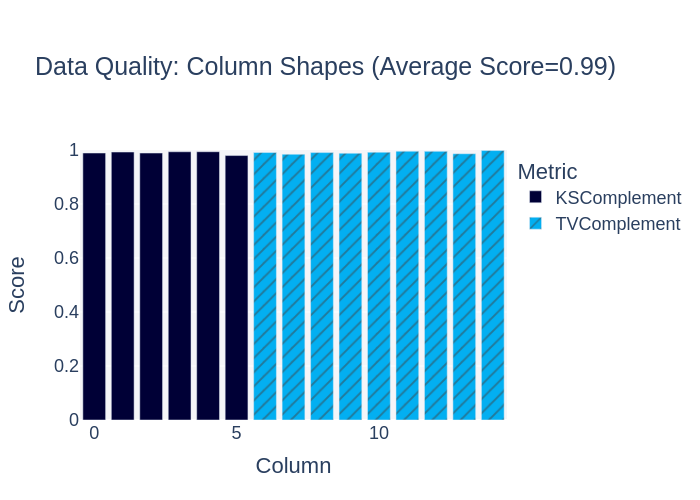

In [ ]:
fig = qual_report.get_visualization(property_name='Column Shapes')
# fig.show()
fig.show(renderer='png')

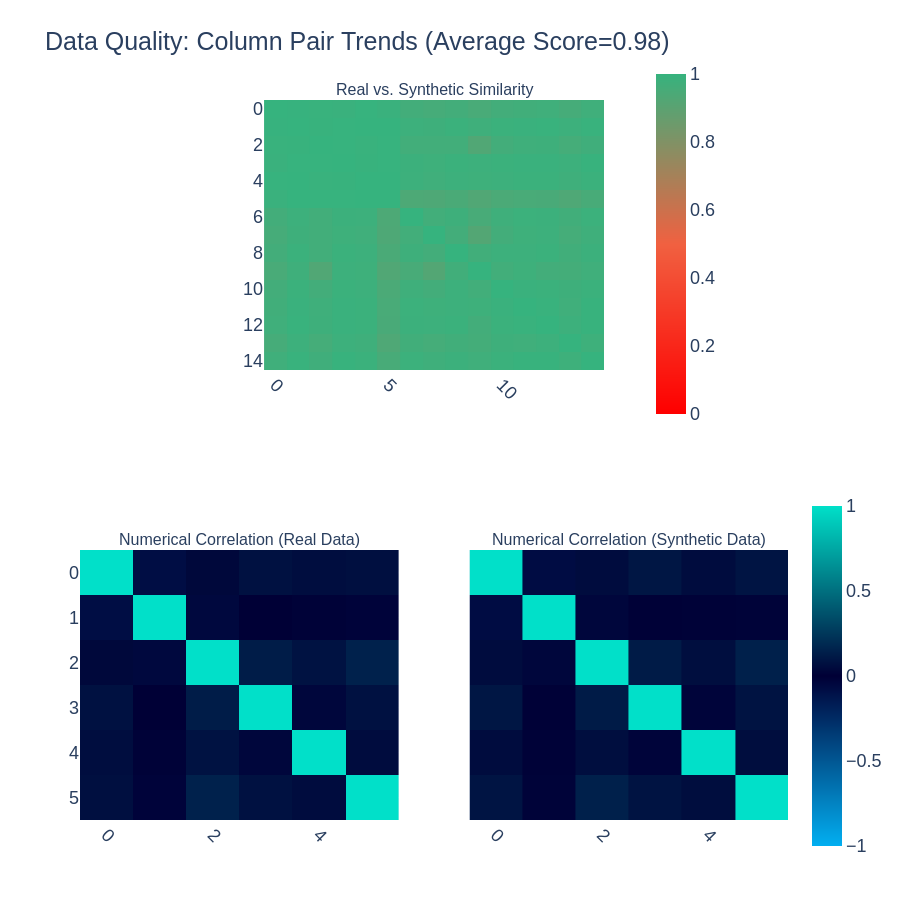

In [ ]:
fig = qual_report.get_visualization(property_name='Column Pair Trends')
fig.show(renderer='png')

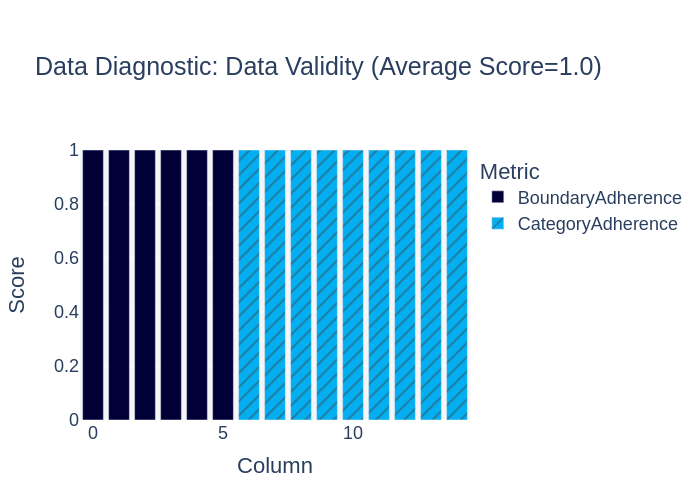

In [ ]:
fig = diag_report.get_visualization(property_name='Data Validity')
fig.show(renderer='png')

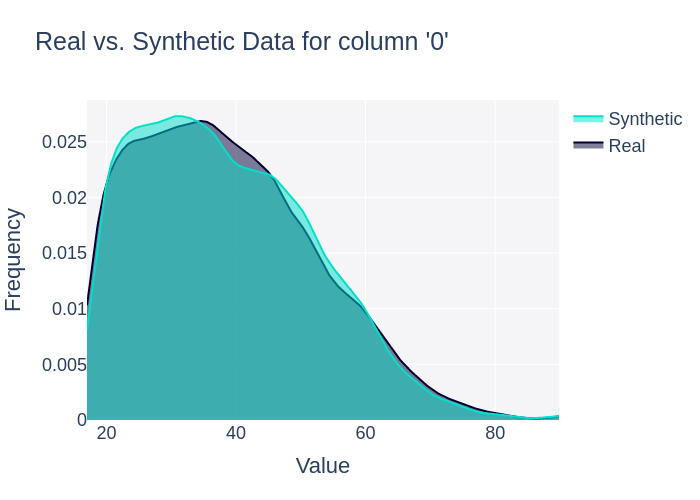

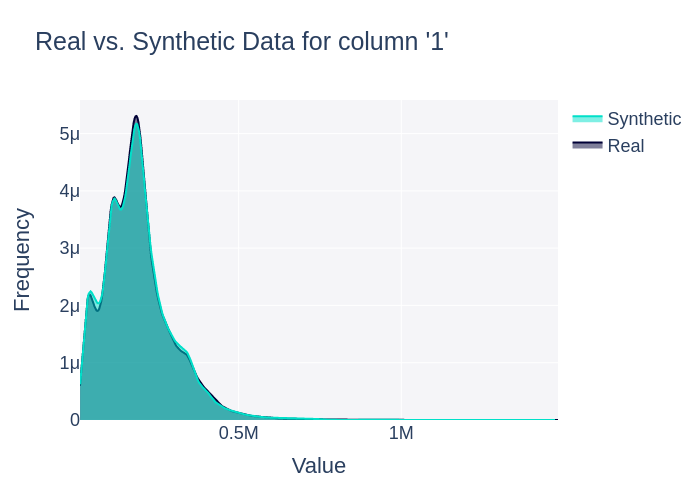

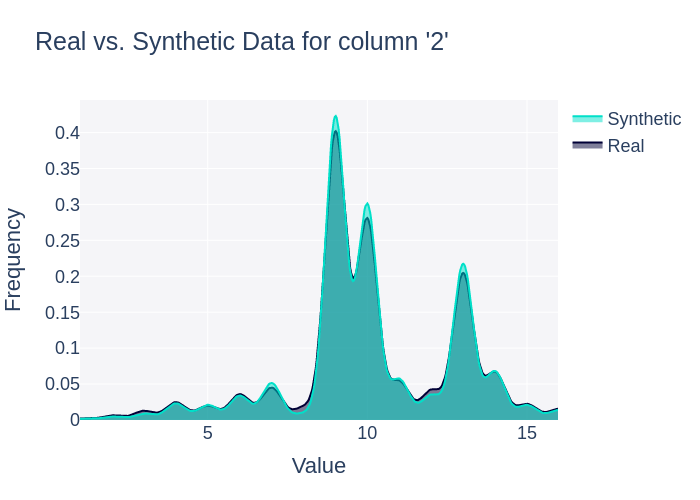

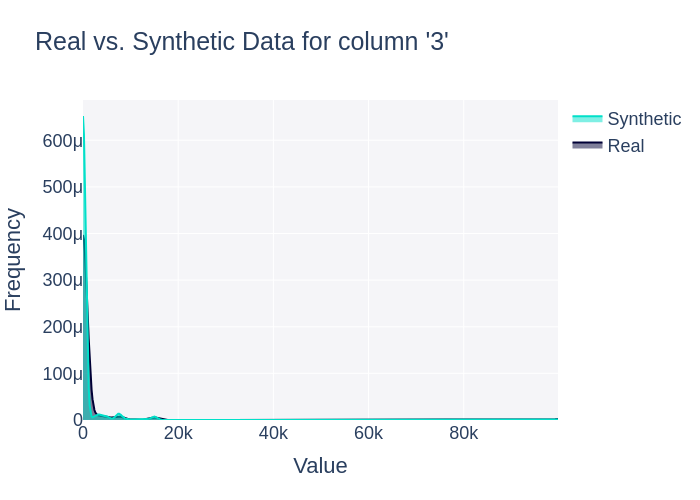

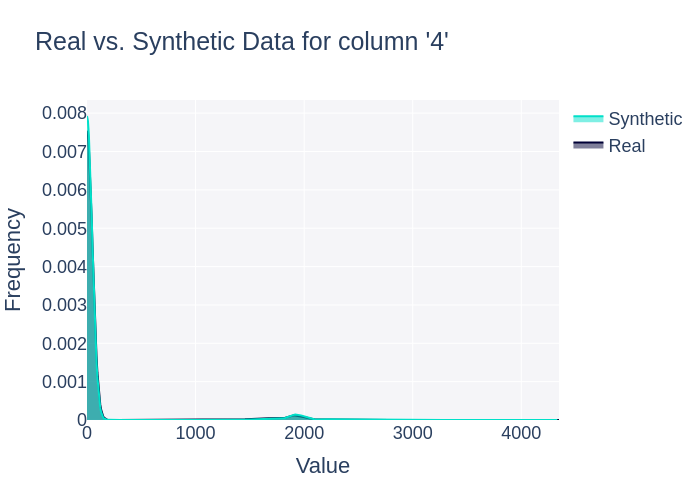

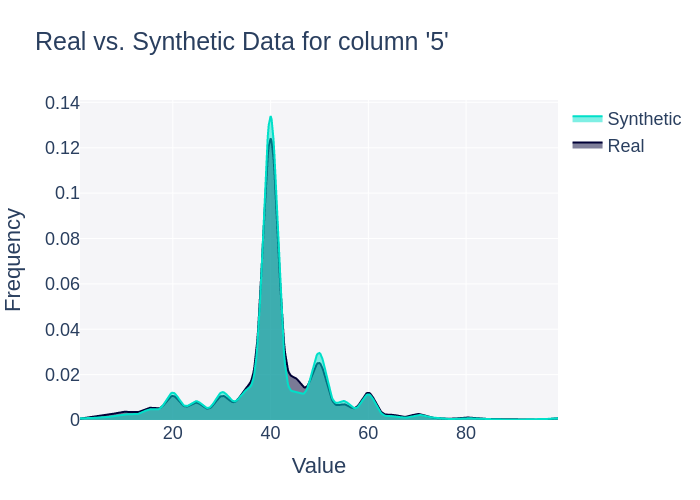

In [ ]:
from sdmetrics.visualization import get_column_plot
for i in range(0, 6):
    fig = get_column_plot(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        column_name=i,
        plot_type='distplot'
    )

    fig.show(renderer='png')

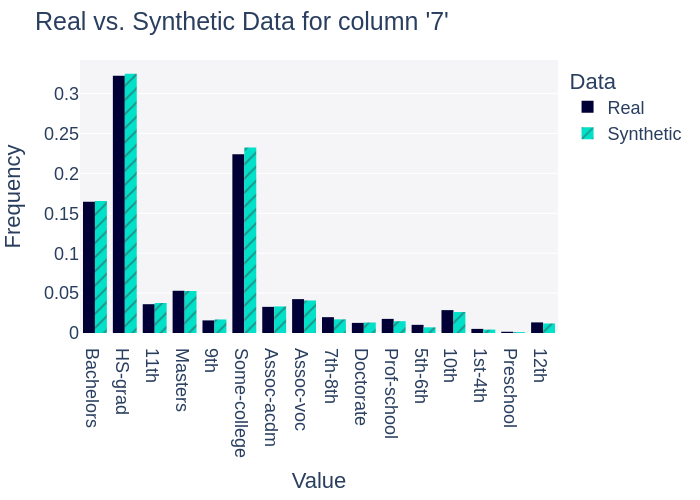

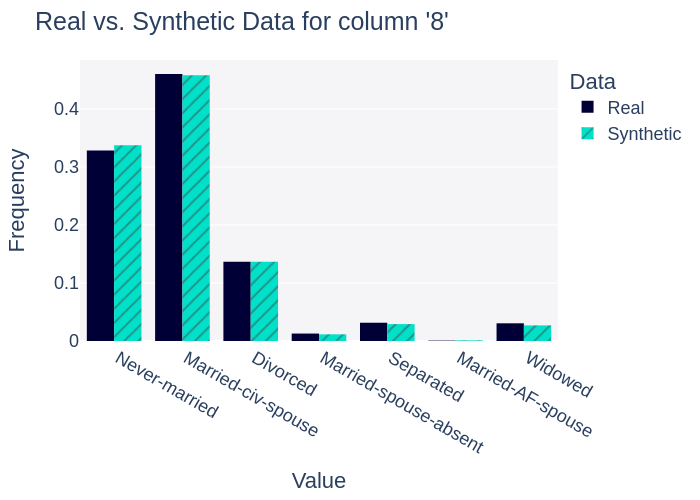

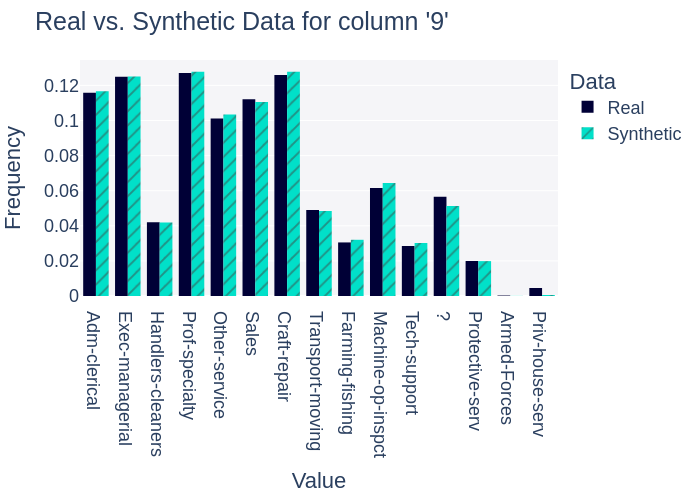

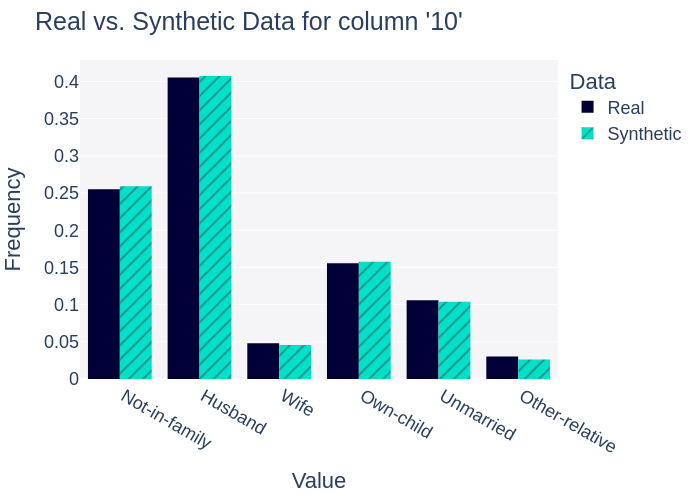

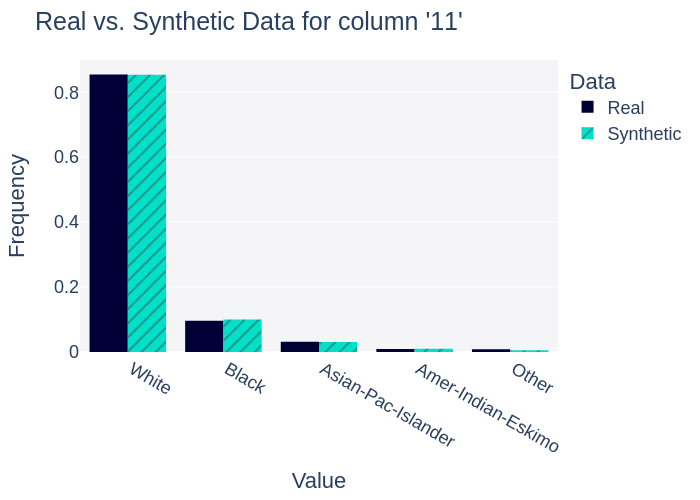

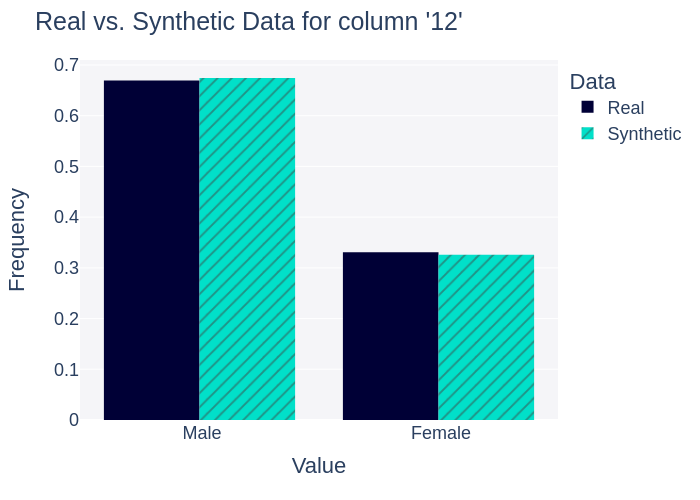

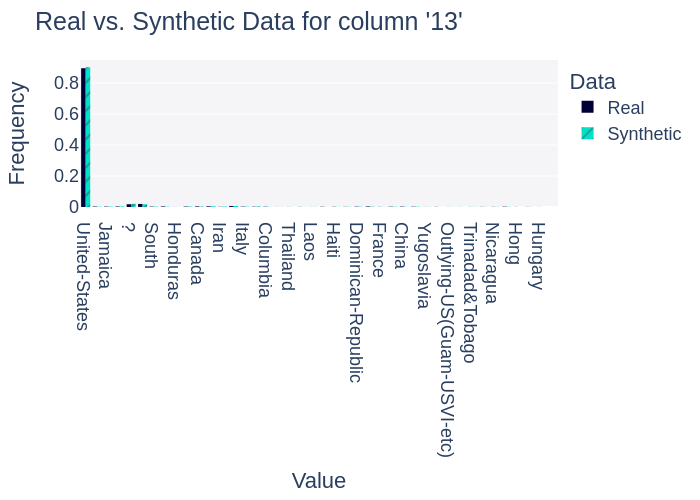

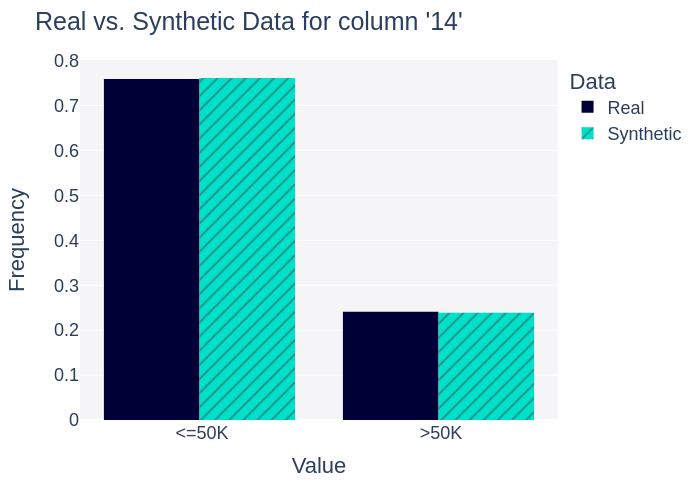

In [ ]:
for i in range(7, 15):
    fig = get_column_plot(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        column_name=i,
        plot_type='bar'
    )

    fig.show(renderer='png')

### DCR

In [ ]:
pd.options.mode.chained_assignment = None

def DCR(dataname = 'adult', model = 'model', syn_path = 'synthetic/adult/synthetic.csv', real_path = f'synthetic/adult/real.csv',test_path = f'synthetic/adult/test.csv', data_dir = f'data/adult' ):
    with open(f'{data_dir}/info.json', 'r') as f:
        info = json.load(f)

    syn_data = pd.read_csv(syn_path)
    real_data = pd.read_csv(real_path)
    test_data = pd.read_csv(test_path)

    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    num_ranges = []

    real_data.columns = list(np.arange(len(real_data.columns)))
    syn_data.columns = list(np.arange(len(real_data.columns)))
    test_data.columns = list(np.arange(len(real_data.columns)))
    for i in num_col_idx:
        num_ranges.append(real_data[i].max() - real_data[i].min())

    num_ranges = np.array(num_ranges)


    num_real_data = real_data[num_col_idx]
    cat_real_data = real_data[cat_col_idx]
    num_syn_data = syn_data[num_col_idx]
    cat_syn_data = syn_data[cat_col_idx]
    num_test_data = test_data[num_col_idx]
    cat_test_data = test_data[cat_col_idx]

    num_real_data_np = num_real_data.to_numpy()
    cat_real_data_np = cat_real_data.to_numpy().astype('str')
    num_syn_data_np = num_syn_data.to_numpy()
    cat_syn_data_np = cat_syn_data.to_numpy().astype('str')
    num_test_data_np = num_test_data.to_numpy()
    cat_test_data_np = cat_test_data.to_numpy().astype('str')

    encoder = OneHotEncoder()
    encoder.fit(cat_real_data_np)


    cat_real_data_oh = encoder.transform(cat_real_data_np).toarray()
    cat_syn_data_oh = encoder.transform(cat_syn_data_np).toarray()
    cat_test_data_oh = encoder.transform(cat_test_data_np).toarray()

    num_real_data_np = num_real_data_np / num_ranges
    num_syn_data_np = num_syn_data_np / num_ranges
    num_test_data_np = num_test_data_np / num_ranges

    real_data_np = np.concatenate([num_real_data_np, cat_real_data_oh], axis=1)
    syn_data_np = np.concatenate([num_syn_data_np, cat_syn_data_oh], axis=1)
    test_data_np = np.concatenate([num_test_data_np, cat_test_data_oh], axis=1)

    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    real_data_th = torch.tensor(real_data_np).to(device)
    syn_data_th = torch.tensor(syn_data_np).to(device)
    test_data_th = torch.tensor(test_data_np).to(device)

    dcrs_real = []
    dcrs_test = []
    batch_size = 100

    batch_syn_data_np = syn_data_np[i*batch_size: (i+1) * batch_size]

    for i in range((syn_data_th.shape[0] // batch_size) + 1):
        if i != (syn_data_th.shape[0] // batch_size):
            batch_syn_data_th = syn_data_th[i*batch_size: (i+1) * batch_size]
        else:
            batch_syn_data_th = syn_data_th[i*batch_size:]

        dcr_real = (batch_syn_data_th[:, None] - real_data_th).abs().sum(dim = 2).min(dim = 1).values
        dcr_test = (batch_syn_data_th[:, None] - test_data_th).abs().sum(dim = 2).min(dim = 1).values
        dcrs_real.append(dcr_real)
        dcrs_test.append(dcr_test)

    dcrs_real = torch.cat(dcrs_real)
    dcrs_test = torch.cat(dcrs_test)


    score = (dcrs_real < dcrs_test).nonzero().shape[0] / dcrs_real.shape[0]

    print('DCR Score, a value closer to 0.5 is better')
    print(f'{dataname}-{model}, DCR Score = {score}')

In [ ]:
DCR()

DCR Score, a value closer to 0.5 is better
adult-model, DCR Score = 0.6665642947083935


### C2ST

In [ ]:
import numpy as np
import torch
import pandas as pd
import os
import sys

import json
import pickle

# Metrics
from sdmetrics import load_demo
from sdmetrics.single_table import LogisticDetection

from matplotlib import pyplot as plt

# import argparse
import warnings
warnings.filterwarnings("ignore")

# parser = argparse.ArgumentParser()
# parser.add_argument('--dataname', type=str, default='adult')
# parser.add_argument('--model', type=str, default='real')

# args = parser.parse_args()

def reorder(real_data, syn_data, info):
    num_col_idx = info['num_col_idx']
    cat_col_idx = info['cat_col_idx']
    target_col_idx = info['target_col_idx']

    task_type = info['task_type']
    if task_type == 'regression':
        num_col_idx += target_col_idx
    else:
        cat_col_idx += target_col_idx

    real_num_data = real_data[num_col_idx]
    real_cat_data = real_data[cat_col_idx]

    new_real_data = pd.concat([real_num_data, real_cat_data], axis=1)
    new_real_data.columns = range(len(new_real_data.columns))

    syn_num_data = syn_data[num_col_idx]
    syn_cat_data = syn_data[cat_col_idx]

    new_syn_data = pd.concat([syn_num_data, syn_cat_data], axis=1)
    new_syn_data.columns = range(len(new_syn_data.columns))


    metadata = info['metadata']

    columns = metadata['columns']
    metadata['columns'] = {}

    inverse_idx_mapping = info['inverse_idx_mapping']


    for i in range(len(new_real_data.columns)):
        if i < len(num_col_idx):
            metadata['columns'][i] = columns[num_col_idx[i]]
        else:
            metadata['columns'][i] = columns[cat_col_idx[i-len(num_col_idx)]]


    return new_real_data, new_syn_data, metadata


def detection(dataname = 'adult', model = 'model',
                syn_path = f'synthetic/adult/synthetic.csv',
              real_path = f'synthetic/adult/real.csv',
                data_dir = f'data/adult' ):
    with open(f'{data_dir}/info.json', 'r') as f:
        info = json.load(f)

    syn_data = pd.read_csv(syn_path)
    real_data = pd.read_csv(real_path)

    save_dir = f'eval/density/{dataname}/{model}'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    real_data.columns = range(len(real_data.columns))
    syn_data.columns = range(len(syn_data.columns))

    metadata = info['metadata']
    metadata['columns'] = {int(key): value for key, value in metadata['columns'].items()}

    new_real_data, new_syn_data, metadata = reorder(real_data, syn_data, info)

    # qual_report.generate(new_real_data, new_syn_data, metadata)

    score = LogisticDetection.compute(
        real_data=new_real_data,
        synthetic_data=new_syn_data,
        metadata=metadata
    )

    print(f'{dataname}, {model}: {score}')

In [ ]:
detection()

adult, model: 0.9755813386333819
